## Motivation for the study:
Motivation for the study is what factors can influence life expectancy. The dataset is taken from the World Health Organization (WHO) and United Nations website for the year 2012 and takes into account 183 countries. The variables included in the dataset include social and economic indicators as well as the effects of diseases and their respective rates of vaccinations. The results of the study would help us understand the major factors influencing life expectancy for different countries and can help determine specific policy actions.

## Variable Description
1. life_expectancy: Life Expectancy in years
2. adult_mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population) 
3. infant_deaths: Number of Infant Deaths per 1000 population
4. alcohol: Alcohol, recorded per capita (15+) consumption (in liters of pure alcohol)
5. percentage_expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
6. hepatitis_b: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
7. bmi: Average Body Mass Index of entire population
8. under_five_deaths: Number of under-five deaths per 1000 population
9. Total_expenditure: General government expenditure on health as a percentage of total government expenditure (%)
10. Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%) 
11. HIV/AIDS: Deaths per 1000 live births HIV/AIDS (0-4 years)
12. GDP: Gross Domestic Product per capita (in USD)
13. Schooling: Number of years of Schooling(years)
14. Polio : Polio immunization coverage among 1-year-olds (%)
15. Africa
16. Oceania 
17. Americas 
18. Europe 
19. Asia 
20. Country
21. Continent

## Question 1
## Part (a): Boruta Algorithm

In [119]:
pip install BorutaShap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
pip install RegscorePy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [121]:
pip install simple-colors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [222]:
import pandas as pd
import statsmodels.stats.api as sms
from simple_colors import *
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
import seaborn as sns
from scipy.stats import bootstrap
from BorutaShap import BorutaShap
from RegscorePy import mallow
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels
from scipy import stats
import matplotlib.pyplot as plt

### Importing the Dataset 

In [123]:
# pd.read_csv('/content/sample_data/430_Data_Cleaned.xlsx')   # starbucks data is still in here if you'd like to see it

In [124]:
df = pd.read_excel("/content/sample_data/430_Data_Cleaned.xlsx", index_col = "Country") 
# to add data to this colab, click on the folder icon on the left. Click on the '...' icon and then 'upload' within a folder (I used the 'content' folder)
df2 = pd.read_csv("/content/sample_data/countryContinent.csv", encoding = "ISO-8859-1") 

df = pd.merge(df, df2[['country', 'continent']], left_on='Country', right_on='country')

df = df.join( pd.get_dummies(df['continent'])  )  # add dummy vars for continent
print(df.columns)
df.head()

Index(['life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'bmi', 'under_five_deaths',
       'polio', 'total_expenditure', 'diphtheria', 'hiv_aids', 'gdp',
       'schooling', 'country', 'continent', 'Africa', 'Americas', 'Asia',
       'Europe', 'Oceania'],
      dtype='object')


,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,bmi,under_five_deaths,polio,total_expenditure,...,hiv_aids,gdp,schooling,country,continent,Africa,Americas,Asia,Europe,Oceania
0,59.5,272,69,0.01,78.184215,67.0,17.6,93,67,8.52,...,0.1,669.959000,9.8,Afghanistan,Asia,0,0,1,0,0
1,76.9,86,0,5.14,412.443356,99.0,55.8,1,99,5.59,...,0.1,4247.614380,14.2,Albania,Europe,0,0,0,1,0
2,75.1,113,21,0.66,555.926083,95.0,56.1,24,95,6.14,...,0.1,5564.825660,14.4,Algeria,Africa,1,0,0,0,0
3,56.0,358,72,8.24,256.122524,75.0,21.5,110,75,3.30,...,2.6,4598.249988,10.3,Angola,Africa,1,0,0,0,0
4,75.9,134,0,8.18,2156.229842,98.0,45.7,0,97,5.39,...,0.2,12565.441970,13.8,Antigua and Barbuda,Americas,0,1,0,0,0


In [125]:
df.isnull().any()

life_expectancy           False
adult_mortality           False
infant_deaths             False
alcohol                    True
percentage_expenditure    False
hepatitis_b                True
bmi                        True
under_five_deaths         False
polio                     False
total_expenditure          True
diphtheria                False
hiv_aids                  False
gdp                        True
schooling                  True
country                   False
continent                 False
Africa                    False
Americas                  False
Asia                      False
Europe                    False
Oceania                   False
dtype: bool

We see that there are NA values present in the dataset. Therefore, in order to impute them, we add the median values instead. The reason for not replacing them with the mean values is because there are extreme values present in the dataset. Due to there being extreme values, median seemed like the more appropriate tool to use in order to impute NA values. 

In [126]:
df = df.fillna(df.median())
df = df.replace(0,df.median())

In [127]:
df.isnull().sum()

life_expectancy           0
adult_mortality           0
infant_deaths             0
alcohol                   0
percentage_expenditure    0
hepatitis_b               0
bmi                       0
under_five_deaths         0
polio                     0
total_expenditure         0
diphtheria                0
hiv_aids                  0
gdp                       0
schooling                 0
country                   0
continent                 0
Africa                    0
Americas                  0
Asia                      0
Europe                    0
Oceania                   0
dtype: int64

Now, we see that all the NA and zero values have been imputed.

In [128]:
# regressions for Harvey Collier test for linearity
ols_fit1 = smf.ols(formula = 'life_expectancy ~ adult_mortality', data =df).fit()
ols_fit2 = smf.ols(formula = 'life_expectancy ~ infant_deaths', data =df).fit()
ols_fit3 = smf.ols(formula = 'life_expectancy ~ alcohol', data =df).fit()
ols_fit4 = smf.ols(formula = 'life_expectancy ~ percentage_expenditure', data =df).fit()
ols_fit5 = smf.ols(formula = 'life_expectancy ~ hepatitis_b', data =df).fit()
ols_fit6 = smf.ols(formula = 'life_expectancy ~ bmi', data =df).fit()
ols_fit7 = smf.ols(formula = 'life_expectancy ~ under_five_deaths', data =df).fit()
ols_fit8 = smf.ols(formula = 'life_expectancy ~ polio', data =df).fit()
ols_fit9 = smf.ols(formula = 'life_expectancy ~ total_expenditure', data =df).fit()
ols_fit10 = smf.ols(formula = 'life_expectancy ~ diphtheria', data =df).fit()
ols_fit11 = smf.ols(formula = 'life_expectancy ~ hiv_aids', data =df).fit()
ols_fit12 = smf.ols(formula = 'life_expectancy ~ gdp', data =df).fit()
ols_fit13 = smf.ols(formula = 'life_expectancy ~ schooling', data =df).fit()

In [129]:
# results of Harvey Collier test for linearity
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit1)
print(blue("Linearity Test Results for adult_mortality:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit2)
print(blue("Linearity Test Results for infant_deaths:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit3)
print(blue("Linearity Test Results for alcohol:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit4)
print(blue("Linearity Test Results for percentage_expenditure:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit5)
print(blue("Linearity Test Results for hepatitis_b:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit6)
print(blue("Linearity Test Results for bmi:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit7)
print(blue("Linearity Test Results for under_five_deaths:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit8)
print(blue("Linearity Test Results for polio:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit9)
print(blue("Linearity Test Results for total_expenditure:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit10)
print(blue("Linearity Test Results for diphtheria:", ['bold']))
print(list(zip(name, test)))
print("\n")

# name = ["t-stat", "p-value"]
# test = sms.linear_harvey_collier(ols_fit11)
# print(blue("Linearity Test Results for hiv/aids:", ['bold']))
# print(list(zip(name, test)))
# print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit12)
print(blue("Linearity Test Results for gdp:", ['bold']))
print(list(zip(name, test)))
print("\n")

name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit13)
print(blue("Linearity Test Results for schooling:", ['bold']))
print(list(zip(name, test)))
print("\n")

Linearity Test Results for adult_mortality:
[('t-stat', -1.2623610028178232), ('p-value', 0.20853780627075733)]


Linearity Test Results for infant_deaths:
[('t-stat', -0.7980353862773476), ('p-value', 0.4259568098087615)]


Linearity Test Results for alcohol:
[('t-stat', 0.09217335961688396), ('p-value', 0.9266681977785822)]


Linearity Test Results for percentage_expenditure:
[('t-stat', -0.5610465243102468), ('p-value', 0.5755002730904755)]


Linearity Test Results for hepatitis_b:
[('t-stat', -0.5601640915966886), ('p-value', 0.5761006250943638)]


Linearity Test Results for bmi:
[('t-stat', -0.5908060496540367), ('p-value', 0.5554304461731521)]


Linearity Test Results for under_five_deaths:
[('t-stat', -0.7399417466671597), ('p-value', 0.4603500032783766)]


Linearity Test Results for polio:
[('t-stat', -0.6216965456529443), ('p-value', 0.534969385826874)]


Linearity Test Results for total_expenditure:
[('t-stat', -0.9248083972233752), ('p-value', 0.3563688148380044)]


Linearit

Using the Harvey-Collier test, we check the linearity of the model. The p-values are all higher than the alpha (0.05) so there is support for the model being linear.

#### Running the Boruta Algorithm

In [130]:
boruta_data = df[["life_expectancy","schooling", "gdp","hiv_aids", "diphtheria", "total_expenditure","polio", "under_five_deaths", "bmi","hepatitis_b", "percentage_expenditure", "alcohol", "infant_deaths", "adult_mortality"]].copy()

  0%|          | 0/50 [00:00<?, ?it/s]

7 attributes confirmed important: ['percentage_expenditure', 'bmi', 'schooling', 'hiv_aids', 'adult_mortality', 'alcohol', 'gdp']
5 attributes confirmed unimportant: ['diphtheria', 'infant_deaths', 'total_expenditure', 'under_five_deaths', 'hepatitis_b']
1 tentative attributes remains: ['polio']


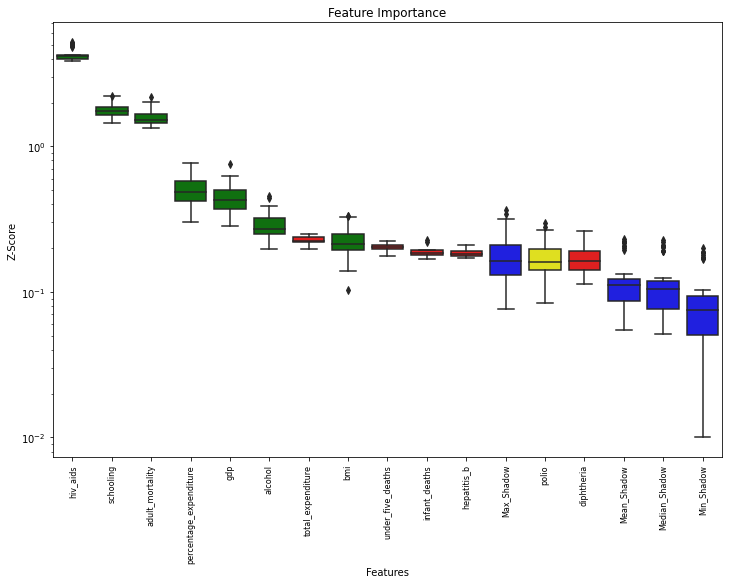

In [131]:
# boruta narrowing to top 10 predictors

x = boruta_data.iloc[:, 1:]
y = boruta_data['life_expectancy']

Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=x, y=y, n_trials=50, random_state=0)
Feature_Selector.plot(which_features='all')

According to Boruta's Algorithm, the top 10 predictors of life expectancy are, hiv_aids, alcohol, percentage_expenditure, adult_mortality, total_expenditure, schooling, bmi, under_five_deaths, diphtheria, polio

#### Mallow's CP

In [132]:
subdat = df[['adult_mortality', 'alcohol', 'bmi', 'total_expenditure', 'percentage_expenditure', 'hiv_aids', 'diphtheria', 'schooling',  'Africa' ,	'Americas' ,	'Asia' ,	'Europe' ,	'Oceania']].copy()

In [133]:
# mallow's cp narrowing to at least 5 predictors

model = smf.ols(formula='life_expectancy ~ adult_mortality +alcohol + bmi +total_expenditure + percentage_expenditure + hiv_aids + diphtheria + schooling + Africa +	Americas +	Asia +	Europe +	Oceania', data = df).fit()
y = df['life_expectancy']
y_hat=model.fittedvalues

storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 14 # number of parameters in orginal model (includes y-intercept)

for L in range(5, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        # join the strings in the data together
        formula1 = 'y~'+'+'.join(subset)
        
        # get the cp
        results = smf.ols(formula=formula1, data = df).fit()
        y_sub = results.fittedvalues
        p = len(subset)+1 # number of parameters in the subset model (includes y-intercept)
        
        cp = mallow.mallow(y, y_hat,y_sub, k, p)
        
        # add to the dataframe
        storage_cp = storage_cp.append({'Variables': subset, 'CP': cp}, ignore_index = True)

In [134]:
# mallow's cp narrowing to at least 5 predictors

storage_cp.sort_values(by = "CP")

,Variables,CP
2637,"(alcohol, bmi, percentage_expenditure, hiv_aid...",30.402871
2928,"(bmi, percentage_expenditure, hiv_aids, diphth...",30.618291
2927,"(bmi, percentage_expenditure, hiv_aids, diphth...",30.715454
3092,"(alcohol, bmi, percentage_expenditure, hiv_aid...",31.336299
3093,"(alcohol, bmi, percentage_expenditure, hiv_aid...",31.586341
...,...,...
574,"(total_expenditure, percentage_expenditure, di...",464.315028
144,"(alcohol, total_expenditure, percentage_expend...",473.777527
411,"(bmi, total_expenditure, Americas, Asia, Oceania)",515.798774
593,"(total_expenditure, percentage_expenditure, Am...",533.903383


According to Mallow's CP, the best performing model includes 8 of the 10 predictors suggested by Boruta's Algorithm:

alcohol,bmi,percentage_expenditure,hiv_aids,diphtheria,schooling,Africa,Oceania

In [135]:
pref_model     = 'life_expectancy ~ alcohol + bmi + percentage_expenditure + hiv_aids + diphtheria + schooling + Africa + Oceania'
alt_pref_model = 'life_expectancy ~ alcohol + bmi + total_expenditure + percentage_expenditure + hiv_aids + diphtheria + schooling'



### THE SUBSET OF VARIABLES FROM MALLOW'S CP 

##### 1.life expectancy ( Y-Variable)
##### 2.BIM
##### 3.HIV/AIDS
##### 4.Percentage expenditure
##### 5.Diptheria
##### 6.Schooling
##### 7.Alcohol
##### 8.Africa
##### 9.Oceania 

## Question 2
### Univariate analysis 
## Part(a) and (b)

In [136]:
import scipy.stats as stats 

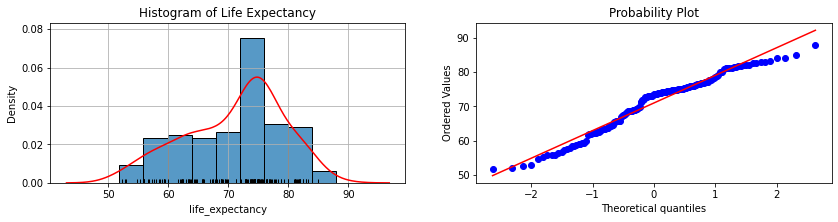

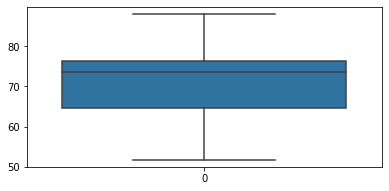

In [224]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of Life Expectancy")
sns.histplot(df.life_expectancy, stat = "density")
sns.kdeplot(df.life_expectancy, color = "red")
sns.rugplot(df.life_expectancy, color = "black")

plt.grid()

plt.subplot(3,2,2)


stats.probplot(df.life_expectancy, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['life_expectancy'])



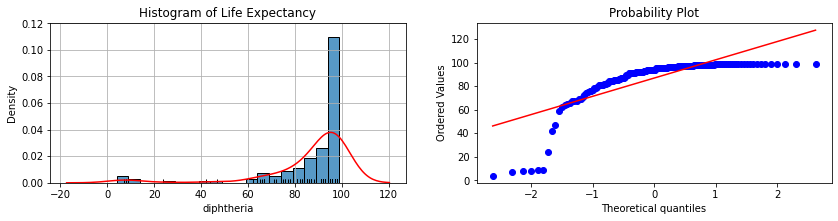

Text(0.5, 1.0, 'Realtionship between diphtheria and life expectancy ')

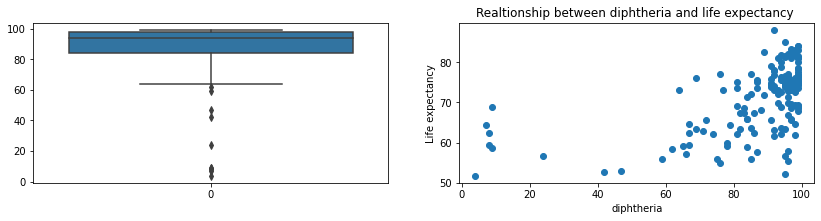

In [212]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of Life Expectancy")
sns.histplot(df.diphtheria, stat = "density")
sns.kdeplot(df.diphtheria, color = "red")
sns.rugplot(df.diphtheria, color = "black")

plt.grid()

plt.subplot(3,2,2)


stats.probplot(df.diphtheria, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['diphtheria'])


plt.subplot(3,2,4)
plt.scatter(df["diphtheria"],df["life_expectancy"])
plt.xlabel("diphtheria")
plt.ylabel("Life expectancy")
plt.title("Realtionship between diphtheria and life expectancy ")


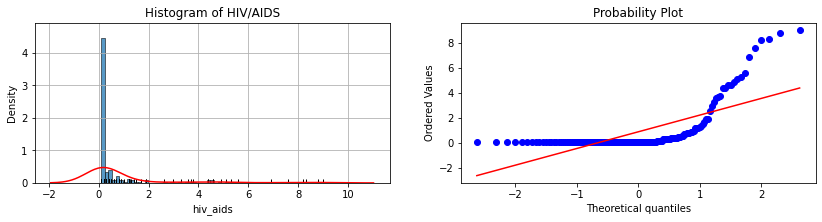

Text(0.5, 1.0, 'Realtionship between hiv_aids and life expectancy ')

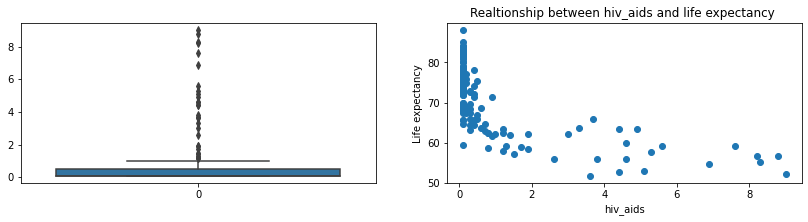

In [213]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of HIV/AIDS")
sns.histplot(df.hiv_aids, stat = "density")
sns.kdeplot(df.hiv_aids, color = "red")
sns.rugplot(df.hiv_aids, color = "black")

plt.grid()

plt.subplot(3,2,2)


stats.probplot(df.hiv_aids, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['hiv_aids'])


plt.subplot(3,2,4)

plt.scatter(df["hiv_aids"],df["life_expectancy"])
plt.xlabel("hiv_aids")
plt.ylabel("Life expectancy")
plt.title("Realtionship between hiv_aids and life expectancy ")


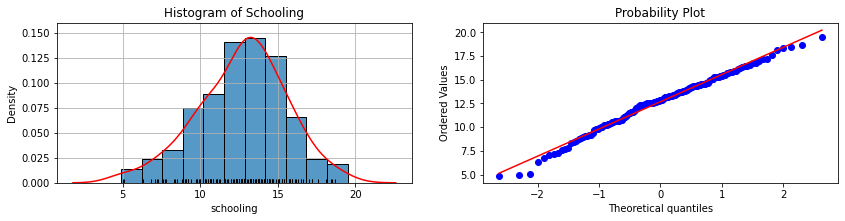

Text(0.5, 1.0, 'Realtionship between schooling and life expectancy ')

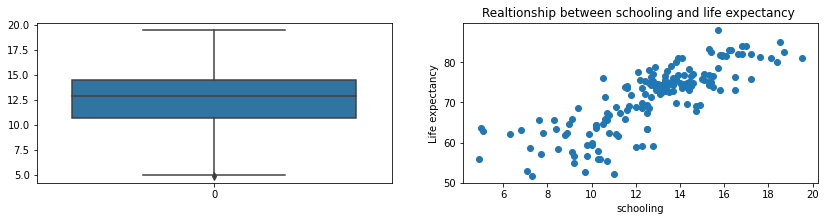

In [215]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of Schooling")
sns.histplot(df.schooling, stat = "density")
sns.kdeplot(df.schooling, color = "red")
sns.rugplot(df.schooling, color = "black")

plt.grid()

plt.subplot(3,2,2)


stats.probplot(df.schooling, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['schooling'])


plt.subplot(3,2,4)

plt.scatter(df["schooling"],df["life_expectancy"])
plt.xlabel("schooling")
plt.ylabel("Life expectancy")
plt.title("Realtionship between schooling and life expectancy ")

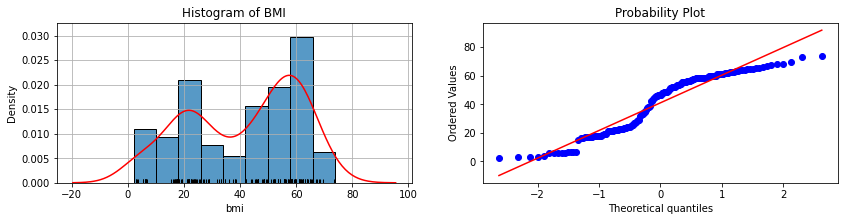

Text(0.5, 1.0, 'Realtionship between bmi and life expectancy ')

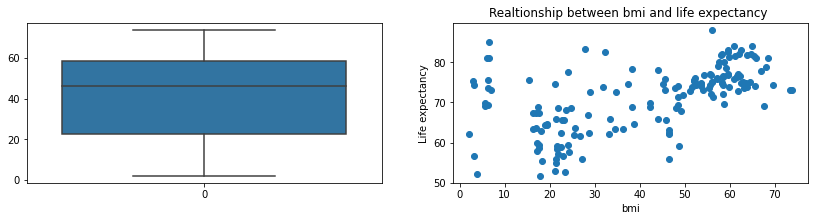

In [216]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of BMI")
sns.histplot(df.bmi, stat = "density")
sns.kdeplot(df.bmi, color = "red")
sns.rugplot(df.bmi, color = "black")

plt.grid()



plt.subplot(3,2,2)


stats.probplot(df.bmi, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['bmi'])


plt.subplot(3,2,4)

plt.scatter(df["bmi"],df["life_expectancy"])
plt.xlabel("bmi")
plt.ylabel("Life expectancy")
plt.title("Realtionship between bmi and life expectancy ")



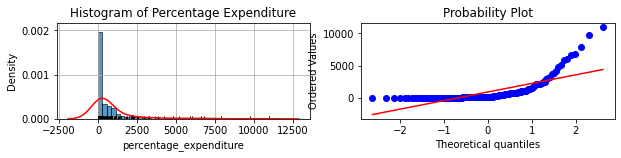

Text(0.5, 1.0, 'Realtionship between Percentage Expenditure and life expectancy ')

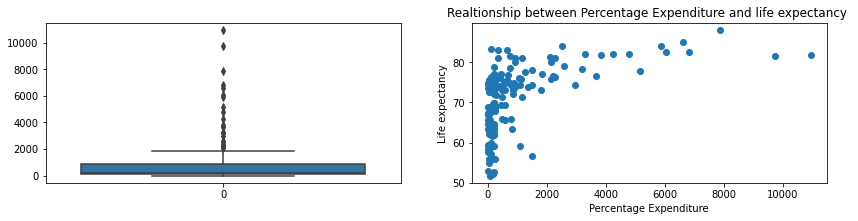

In [226]:

plt.figure(figsize=(10,6))

plt.subplot(3,2,1)

plt.title("Histogram of Percentage Expenditure")
sns.histplot(df.percentage_expenditure, stat = "density")
sns.kdeplot(df.percentage_expenditure, color = "red")
sns.rugplot(df.percentage_expenditure, color = "black")

plt.grid()

plt.subplot(3,2,2)


stats.probplot(df.percentage_expenditure, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['percentage_expenditure'])

plt.subplot(3,2,4)

plt.scatter(df["percentage_expenditure"],df["life_expectancy"])
plt.xlabel("Percentage Expenditure")
plt.ylabel("Life expectancy")
plt.title("Realtionship between Percentage Expenditure and life expectancy ")

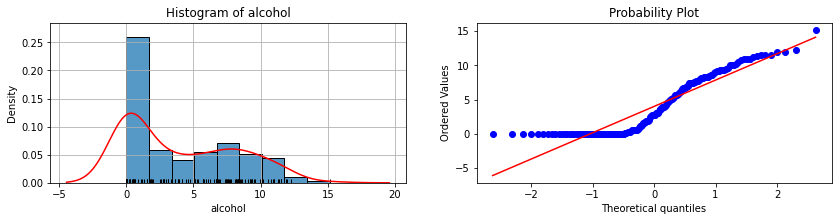

Text(0.5, 1.0, 'Realtionship between alcohol and life expectancy ')

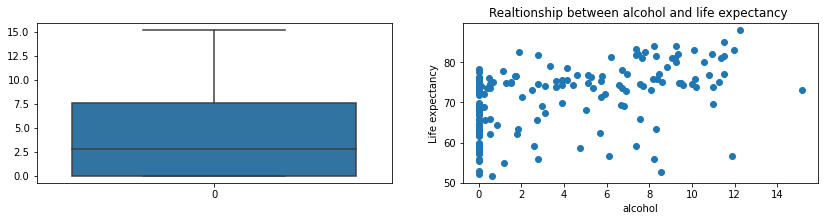

In [221]:
plt.figure(figsize = (14,10))

plt.subplot(3,2,1)

plt.title("Histogram of alcohol")
sns.histplot(df.alcohol, stat = "density")
sns.kdeplot(df.alcohol, color = "red")
sns.rugplot(df.alcohol, color = "black")

plt.grid()



plt.subplot(3,2,2)


stats.probplot(df.alcohol, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))

plt.subplot(3,2,3)

sns.boxplot(data = df['alcohol'])


plt.subplot(3,2,4)

plt.scatter(df["alcohol"],df["life_expectancy"])
plt.xlabel("alcohol")
plt.ylabel("Life expectancy")
plt.title("Realtionship between alcohol and life expectancy ")


#### Quantile Plots 

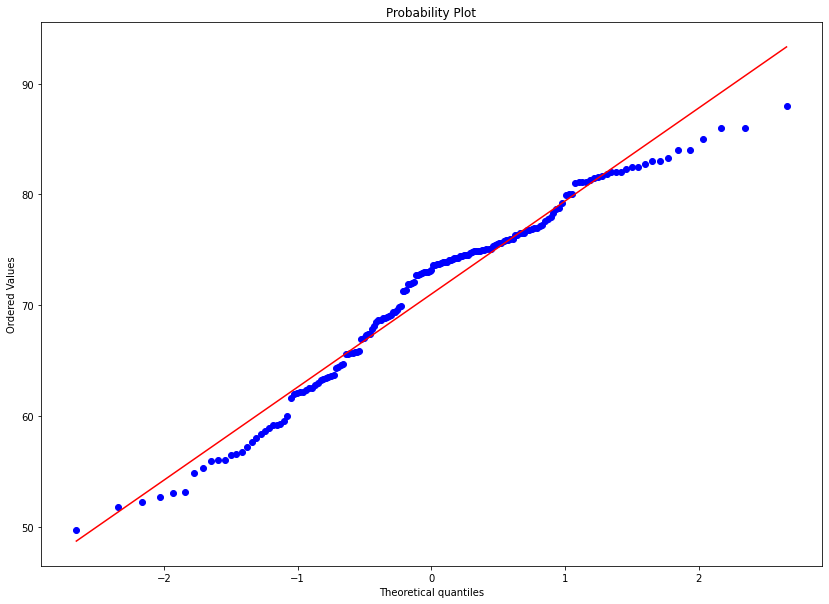

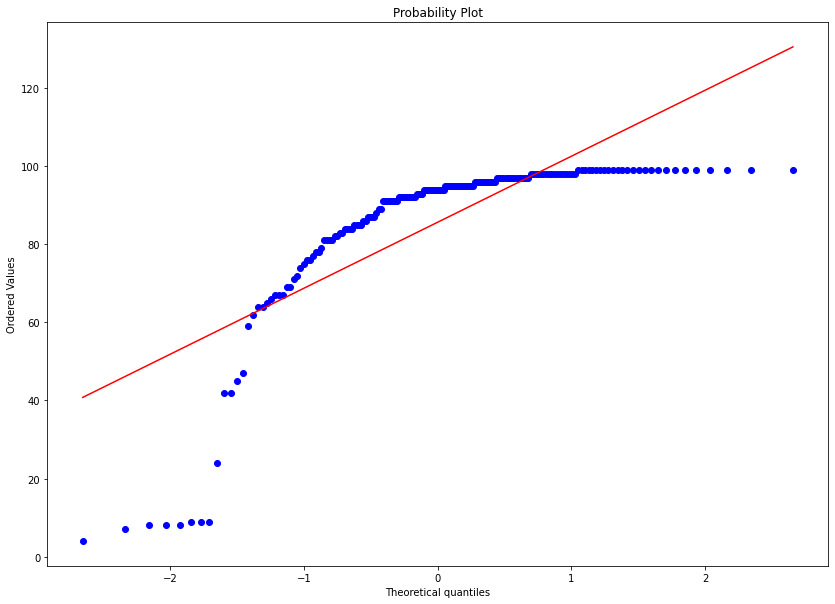

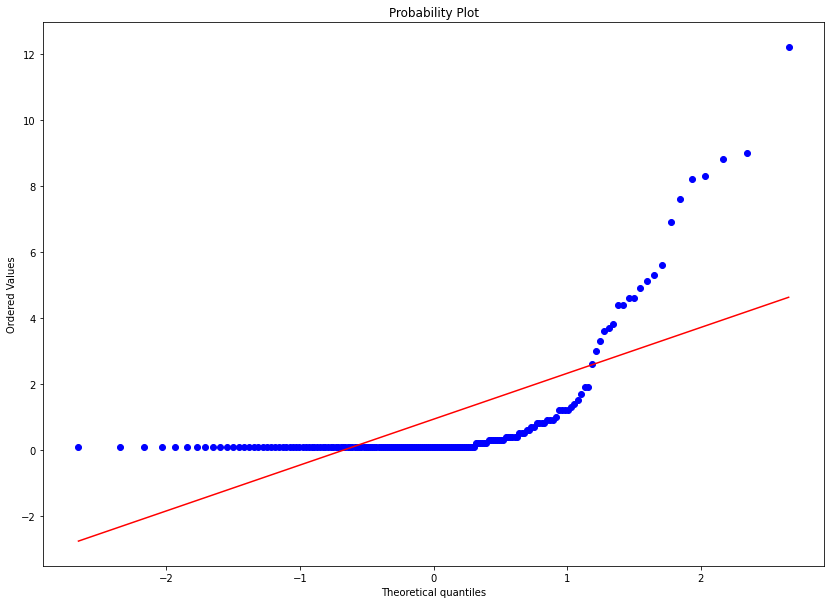

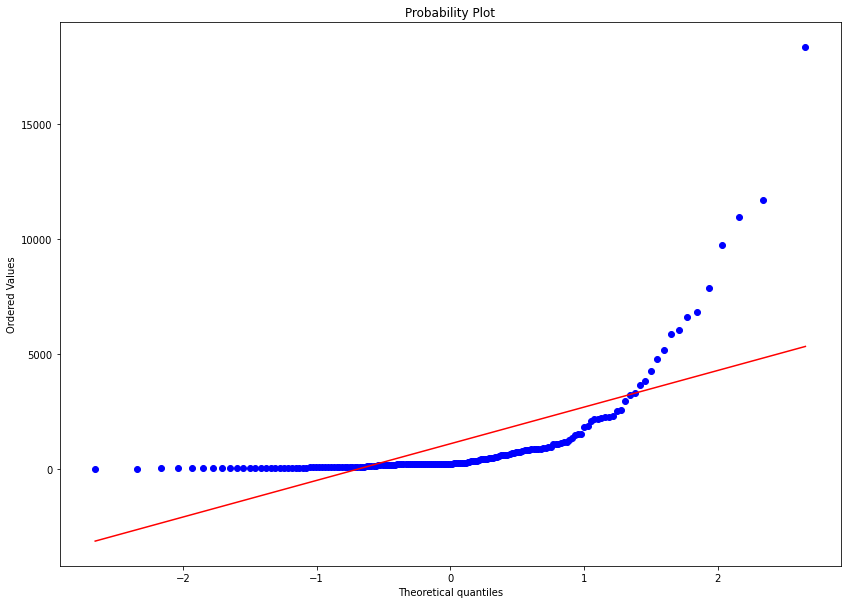

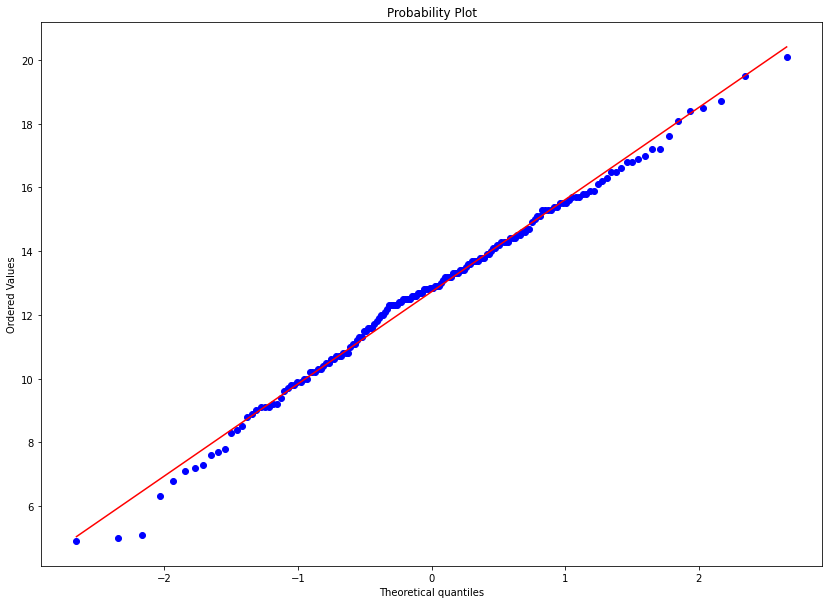

<Figure size 1008x720 with 0 Axes>

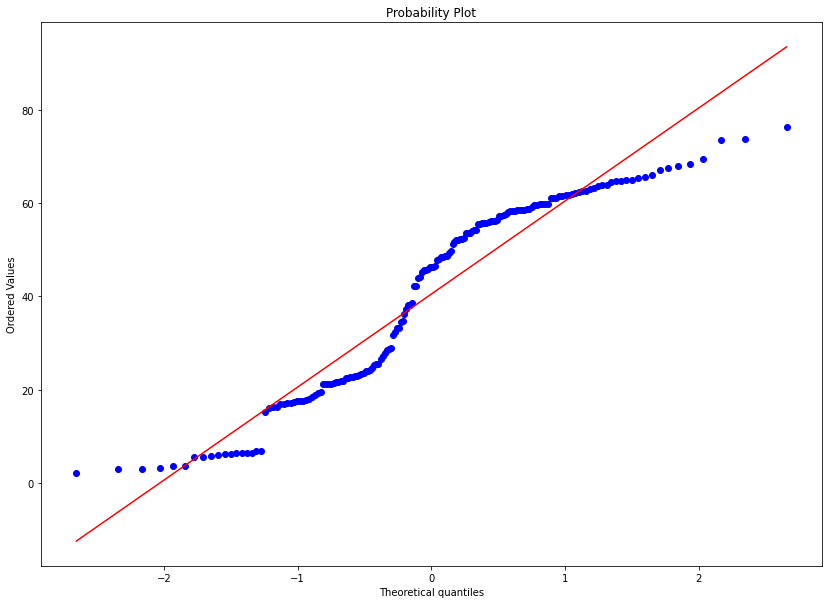

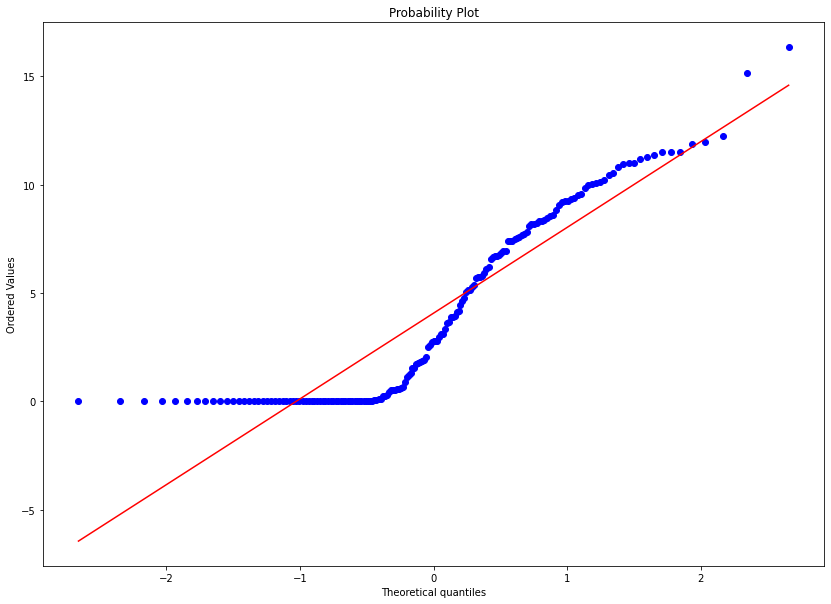

In [144]:
plt.figure(figsize = (14,10))

stats.probplot(df.life_expectancy, dist="norm", plot=plt)
plt.show()
plt.figure(figsize = (14,10))

stats.probplot(df.diphtheria, dist="norm", plot=plt)
plt.show()
plt.figure(figsize = (14,10))

stats.probplot(df.hiv_aids, dist="norm", plot=plt)
plt.show()
plt.figure(figsize = (14,10))

stats.probplot(df.percentage_expenditure, dist="norm", plot=plt)
plt.show()
plt.figure(figsize = (14,10))

stats.probplot(df.schooling, dist="norm", plot=plt)
plt.show()
plt.figure(figsize = (14,10))

plt.figure(figsize = (14,10))
stats.probplot(df.bmi, dist="norm", plot=plt)
plt.show()

plt.figure(figsize = (14,10))
stats.probplot(df.alcohol, dist="norm", plot=plt)
plt.show()


#### Residual Plots 

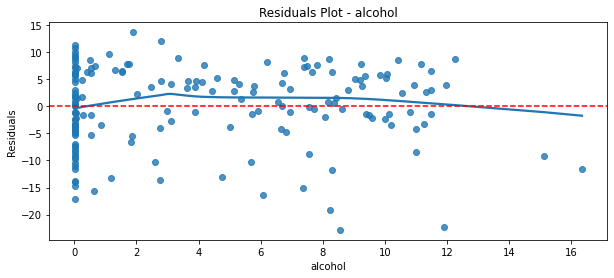

In [145]:
reg = smf.ols('life_expectancy ~ alcohol', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.alcohol, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - alcohol")
plt.show()

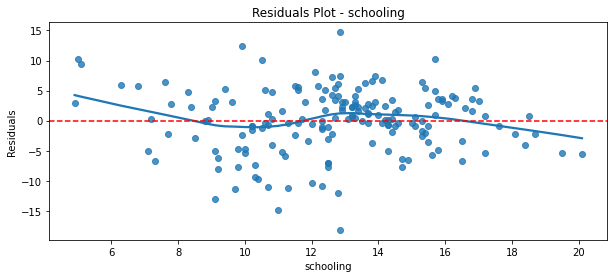

In [146]:
reg = smf.ols('life_expectancy ~ schooling', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.schooling, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - schooling")
plt.show()

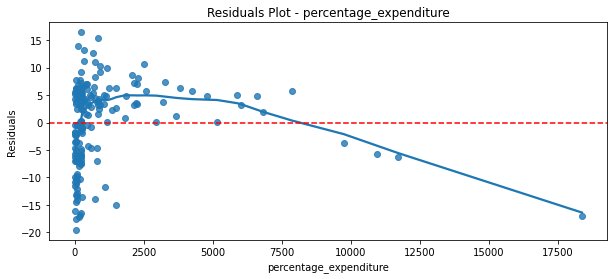

In [147]:
reg = smf.ols('life_expectancy ~ percentage_expenditure', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.percentage_expenditure, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - percentage_expenditure")
plt.show()

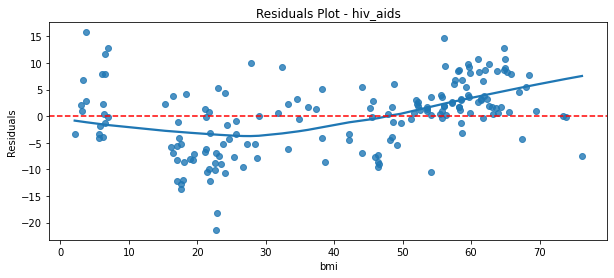

In [148]:
reg = smf.ols('life_expectancy ~ hiv_aids', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.bmi, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - hiv_aids")
plt.show()

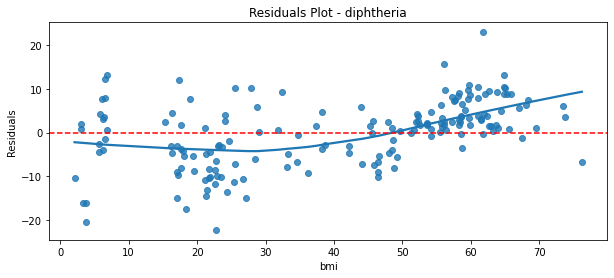

In [149]:
reg = smf.ols('life_expectancy ~ diphtheria', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.bmi, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - diphtheria")
plt.show()

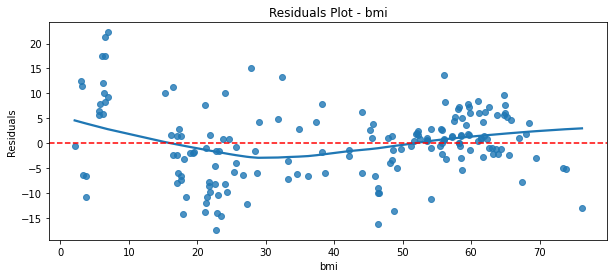

In [150]:
reg = smf.ols('life_expectancy ~ bmi', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.bmi, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - bmi")
plt.show()

The residuals seem to be randomly distributed about the residual line (=0). Since the residuals are randomly scattered around the residual = 0, it means that a linear model approximates the data points well without favoring certain inputs. In such a case, we conclude that a linear model is appropriate. ****

<Figure size 720x720 with 0 Axes>

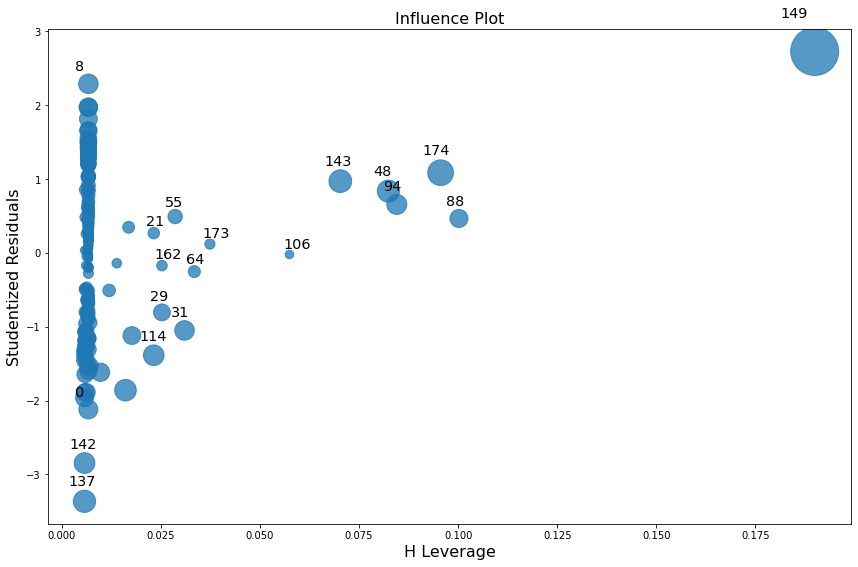

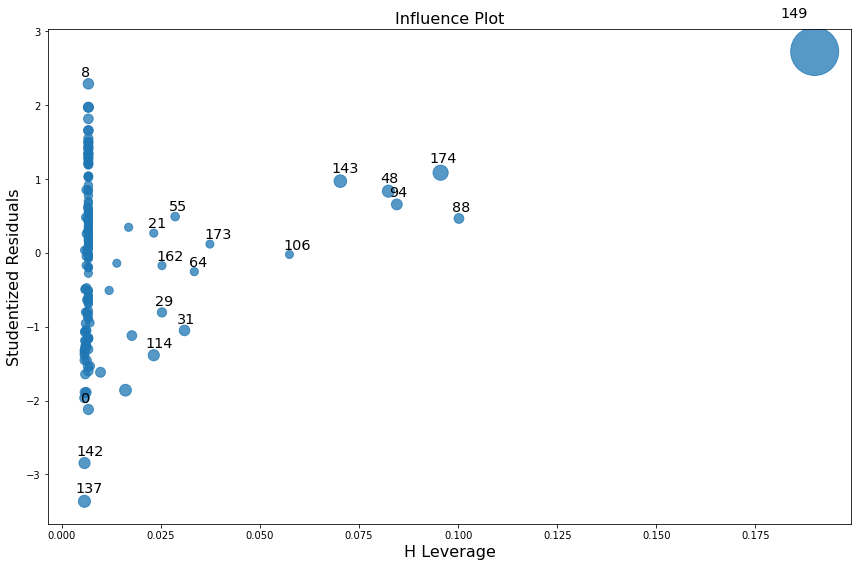

<Figure size 720x720 with 0 Axes>

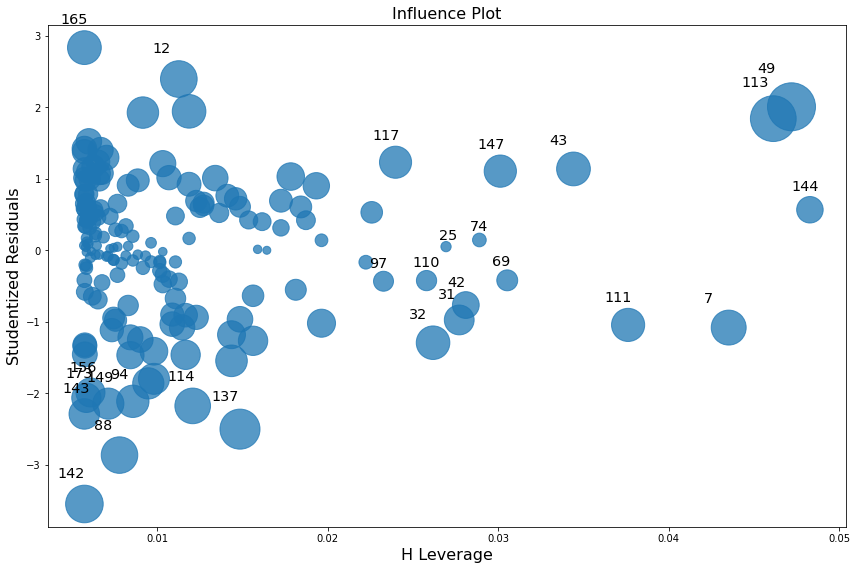

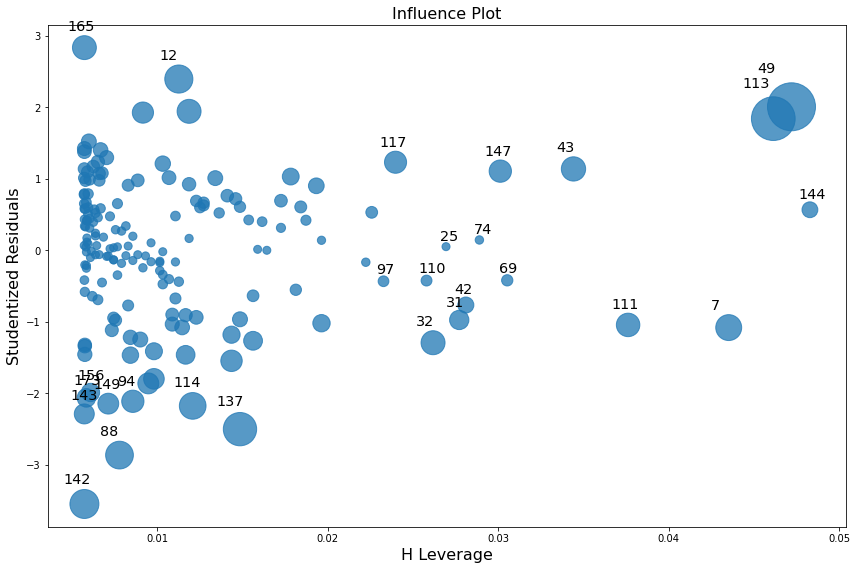

<Figure size 720x720 with 0 Axes>

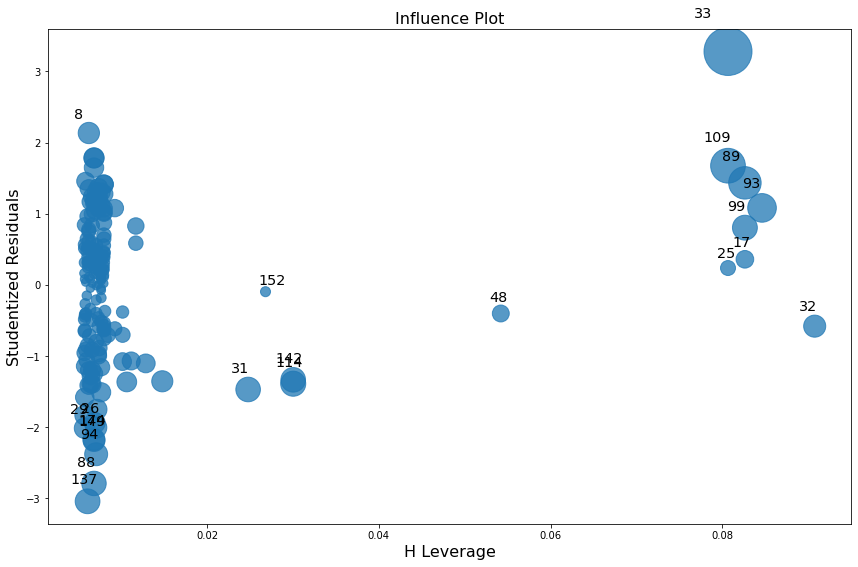

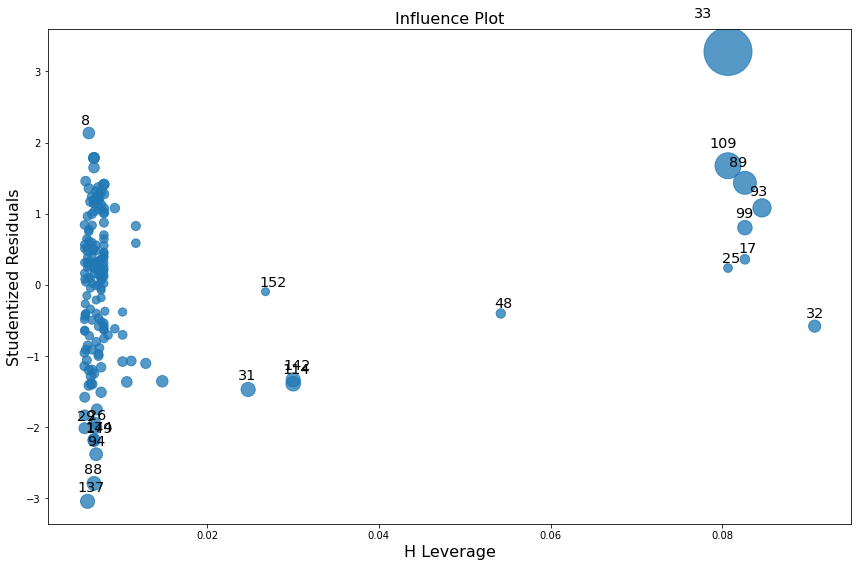

<Figure size 720x720 with 0 Axes>

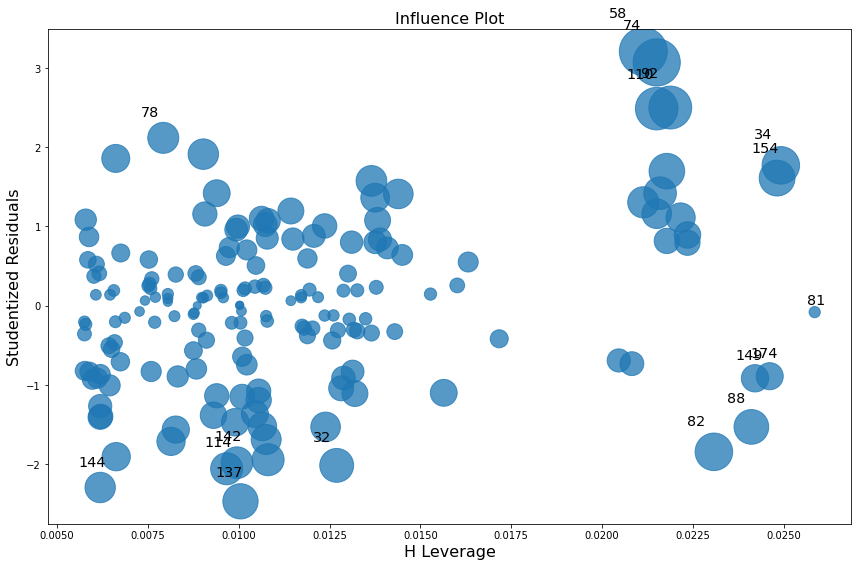

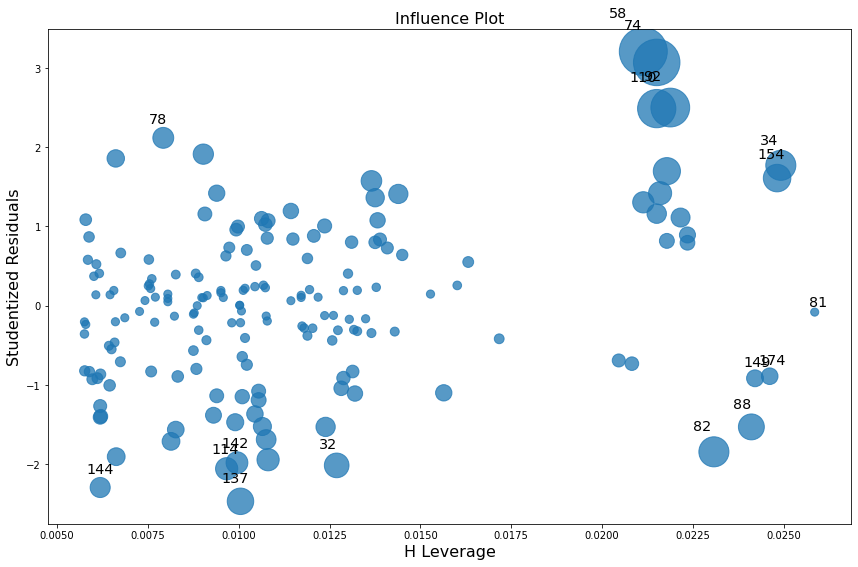

<Figure size 720x720 with 0 Axes>

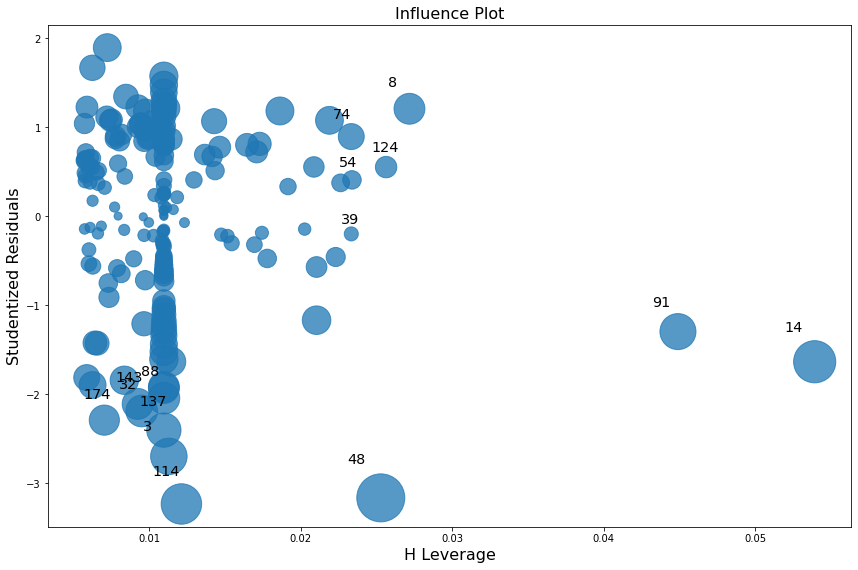

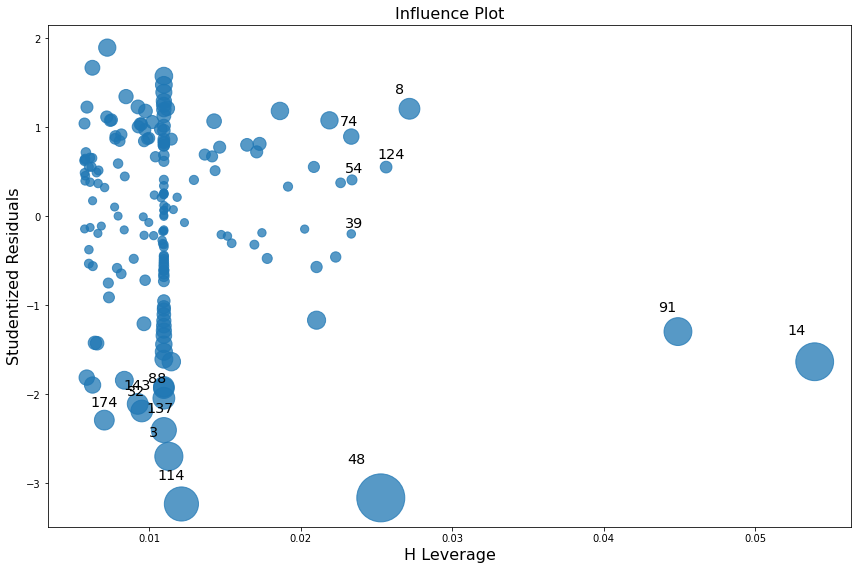

<Figure size 720x720 with 0 Axes>

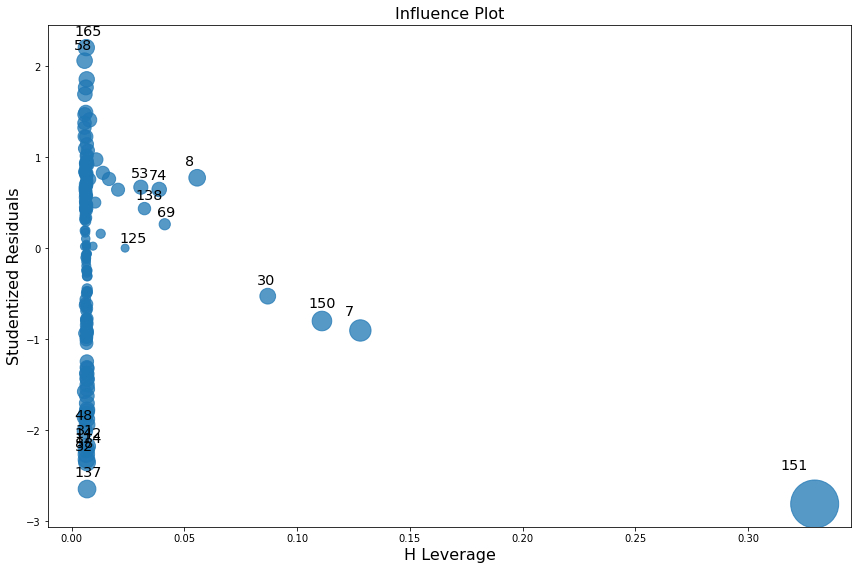

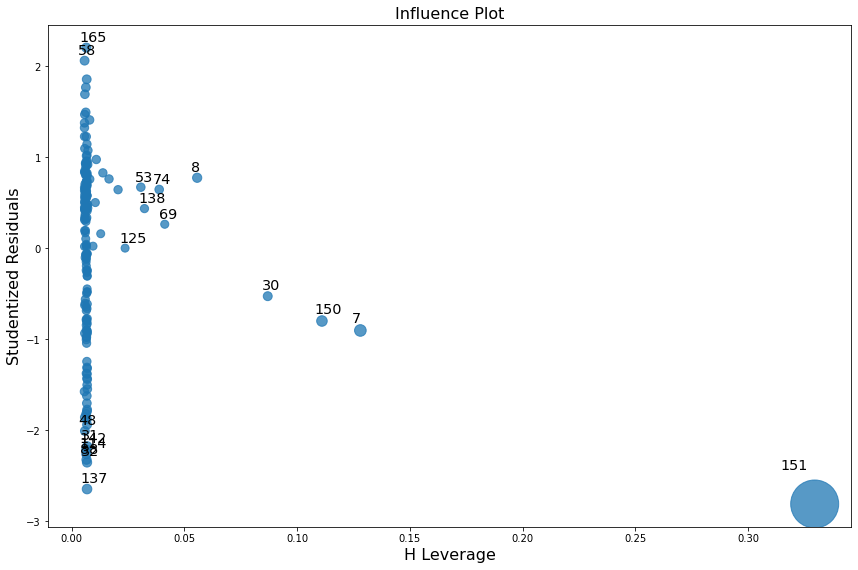

In [151]:
##
plt.figure(figsize=(10,10))

ols_mod11 = smf.ols(formula = 'life_expectancy ~ hiv_aids', data =df)
ols_fit11 = ols_mod11.fit()
# For hiv/aids
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit11, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit11, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)
##
plt.figure(figsize=(10,10))

ols_mod13 = smf.ols(formula = 'life_expectancy ~ schooling', data =df)
ols_fit13 = ols_mod13.fit()
# For schooling
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit13, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit13, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)
##

plt.figure(figsize=(10,10))

ols_mod9 = smf.ols(formula = 'life_expectancy ~ diphtheria', data =df)
ols_fit9 = ols_mod9.fit()
# For total expenditure
plt.title
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit9, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit9, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)
##

plt.figure(figsize=(10,10))

ols_mod1 = smf.ols(formula = 'life_expectancy ~ bmi', data =df)
ols_fit1 = ols_mod1.fit()
#For adult mortality
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit1, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit1, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)
##

plt.figure(figsize=(10,10))

ols_mod3 = smf.ols(formula = 'life_expectancy ~ alcohol', data =df)
ols_fit3 = ols_mod3.fit()
# For alcohol
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit3, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit3, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)

plt.figure(figsize=(10,10))

ols_mod1 = smf.ols(formula = 'life_expectancy ~ percentage_expenditure', data =df)
ols_fit1 = ols_mod1.fit()
#For adult mortality
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit1, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit1, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)
##

#### Pairplot 

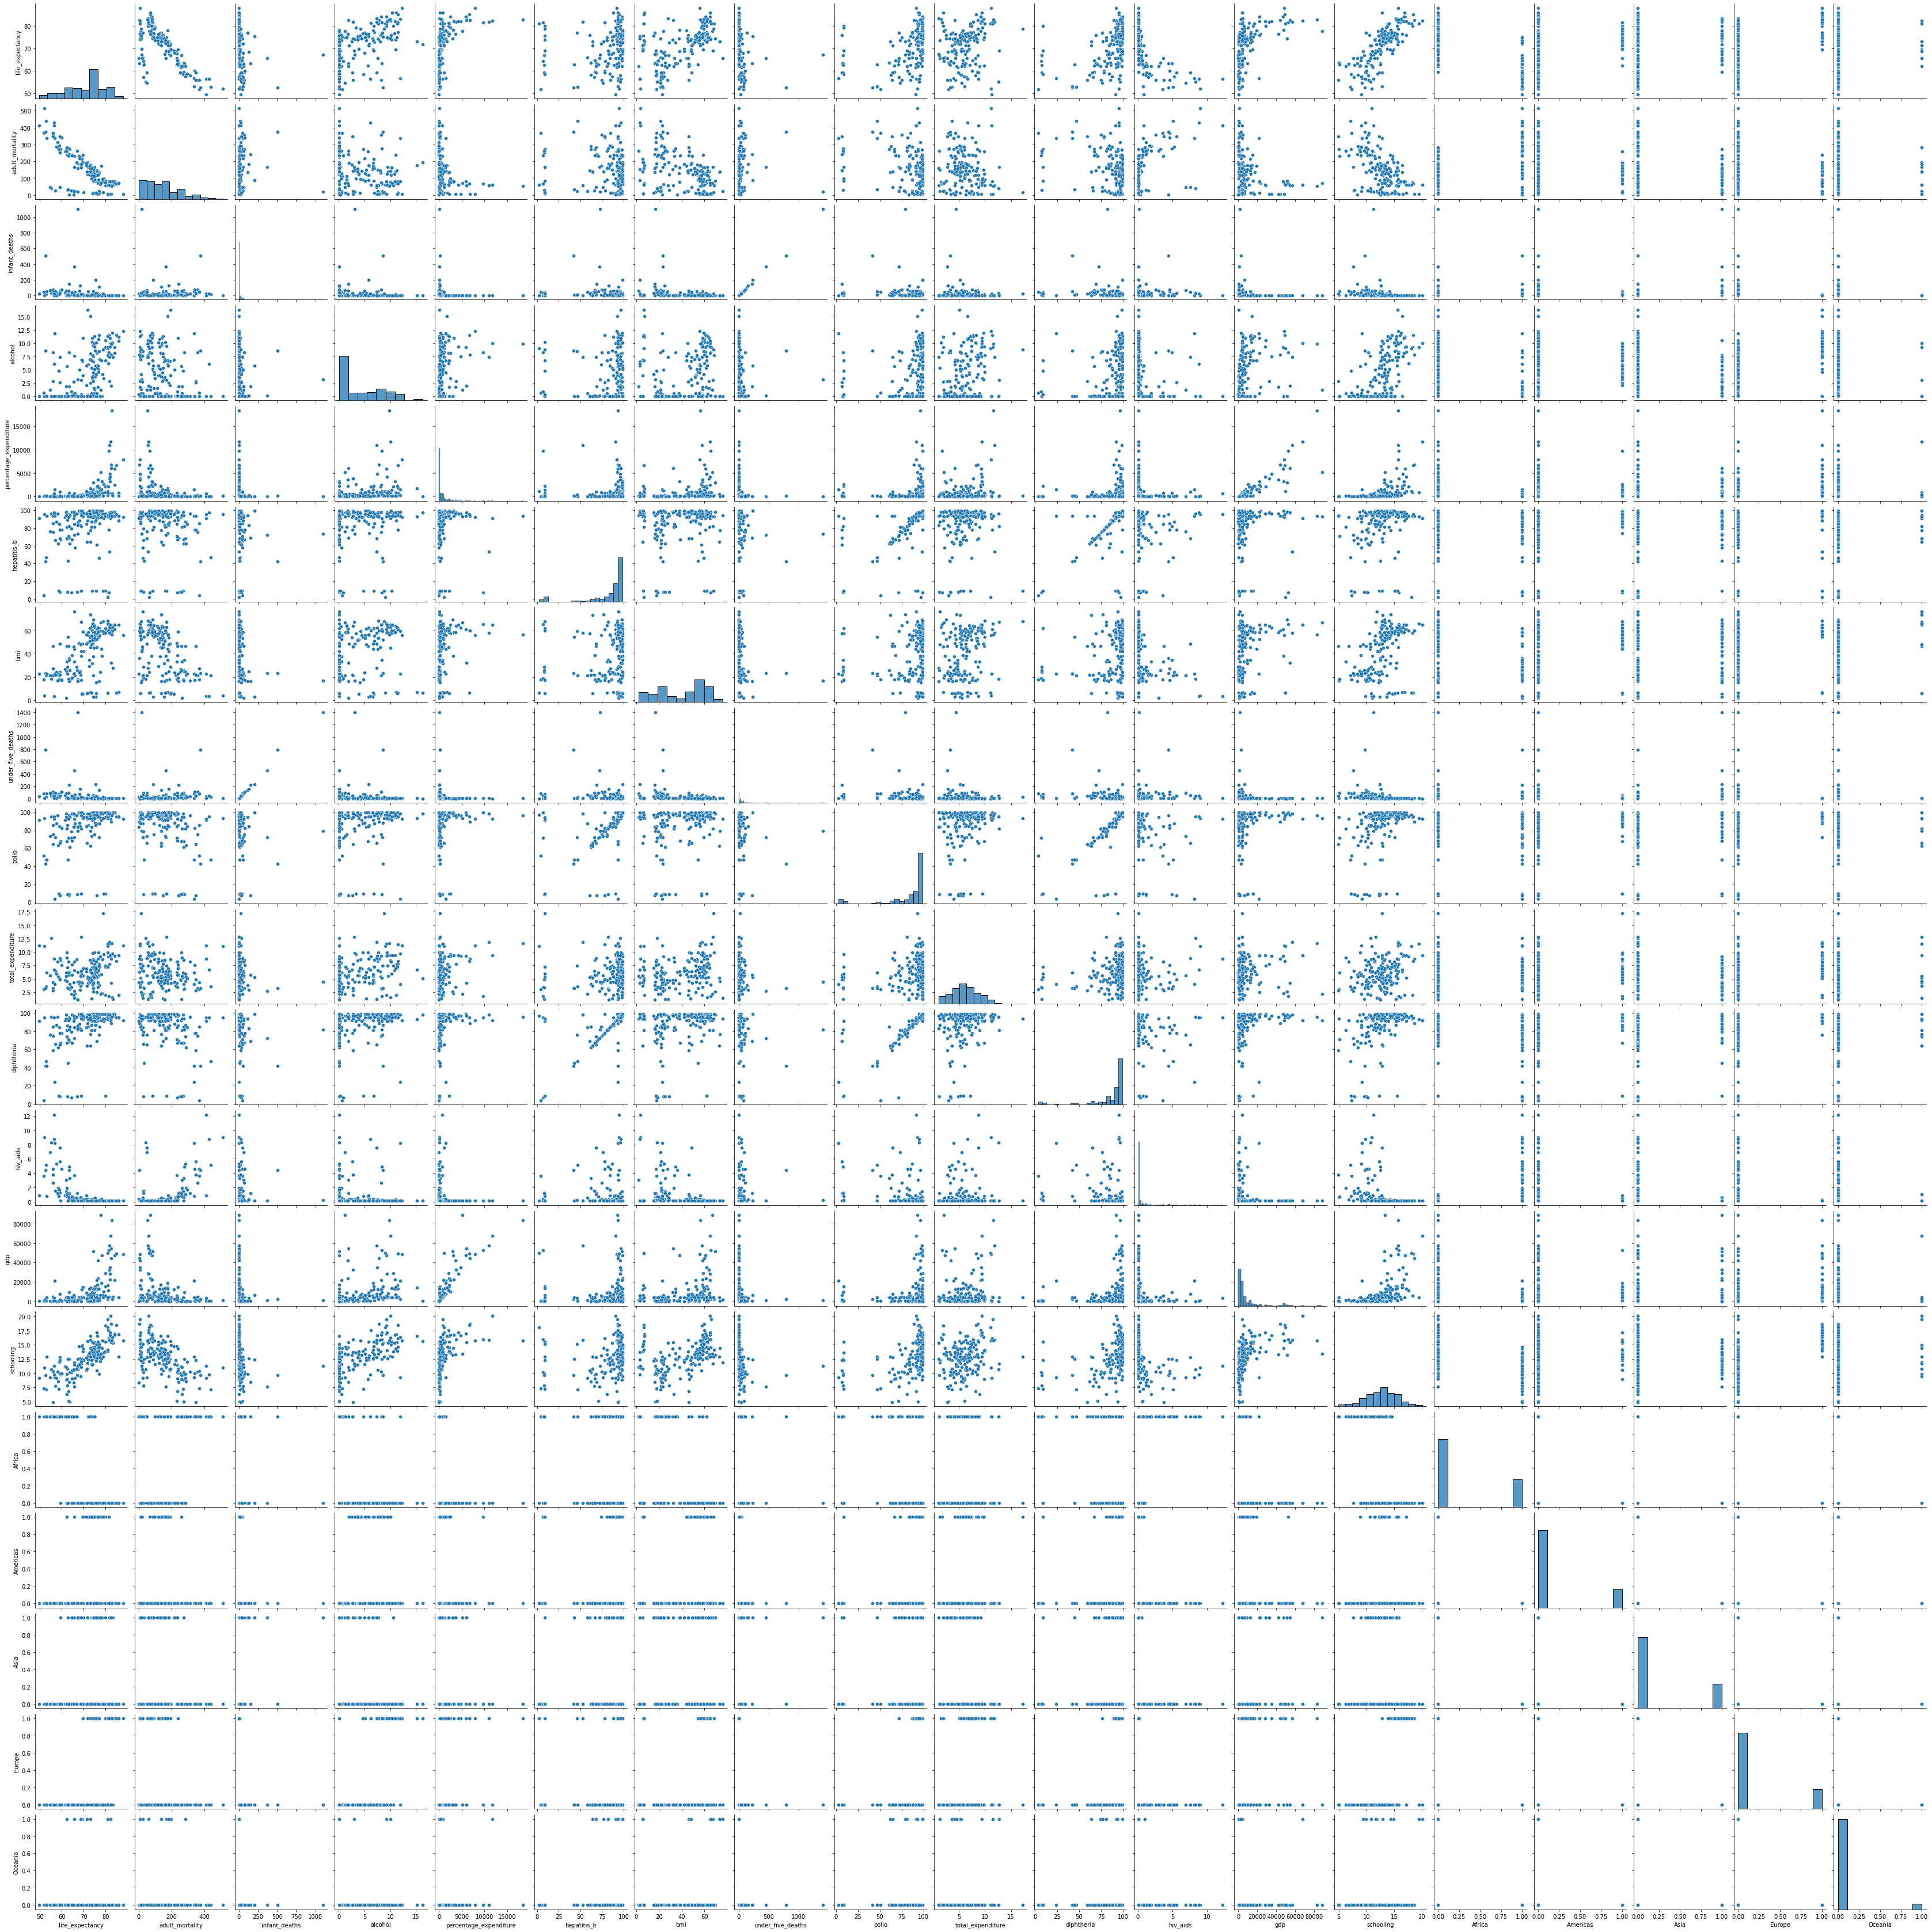

In [152]:
sns.pairplot(df)

#### Correlation Matrix 

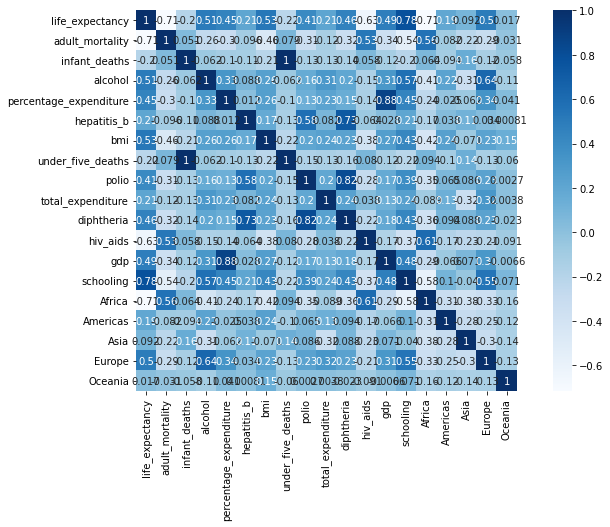

In [153]:
plt.figure(figsize=(13,7))
c= df.corr()
sns.heatmap(c,cmap="Blues",annot=True,square = True)

#### Scatter Plots

The slope of the regression line is: 0.001662229374351855 The Intercept is: 69.20308722093486


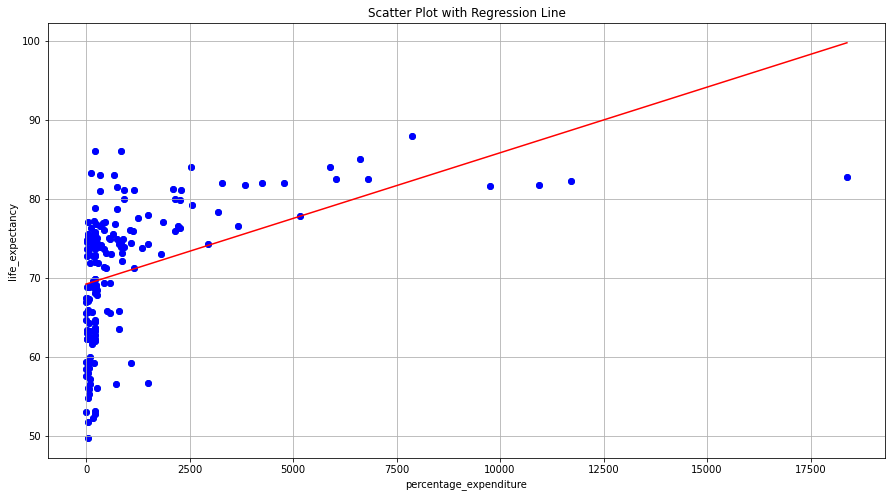

In [154]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["percentage_expenditure"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["percentage_expenditure"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(0, df.percentage_expenditure.max(), 100)

# combining the two plots
plt.scatter(df["percentage_expenditure"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("percentage_expenditure")
plt.grid()

In [155]:
df.adult_mortality.max()

513

The slope of the regression line is: 1.0123386295715437 The Intercept is: 66.89219159960423


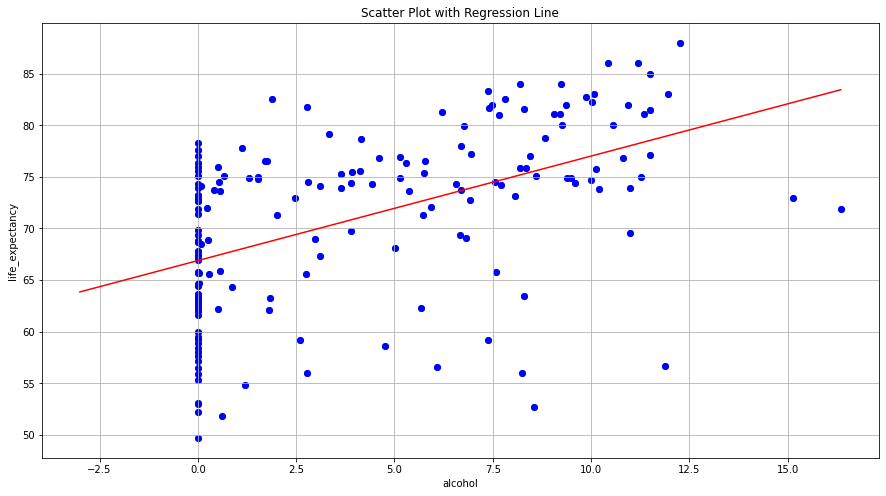

In [156]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["alcohol"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["alcohol"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(-3, df.alcohol.max(), 100)

# combining the two plots
plt.scatter(df["alcohol"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("alcohol")
plt.grid()

The slope of the regression line is: -2.688032124614532 The Intercept is: 73.4975292218568


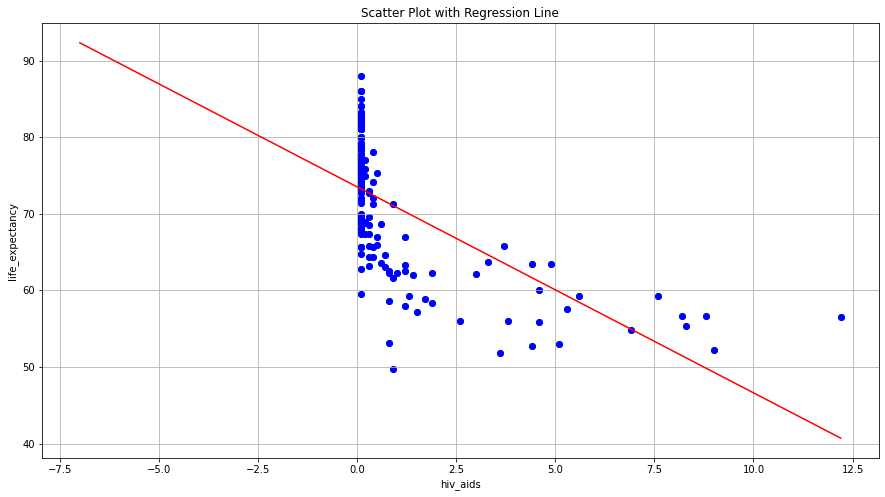

In [157]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["hiv_aids"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["hiv_aids"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(-7, df.hiv_aids.max(), 100)

# combining the two plots
plt.scatter(df["hiv_aids"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("hiv_aids")
plt.grid()

The slope of the regression line is: 2.293071348669156 The Intercept is: 41.824255771892695


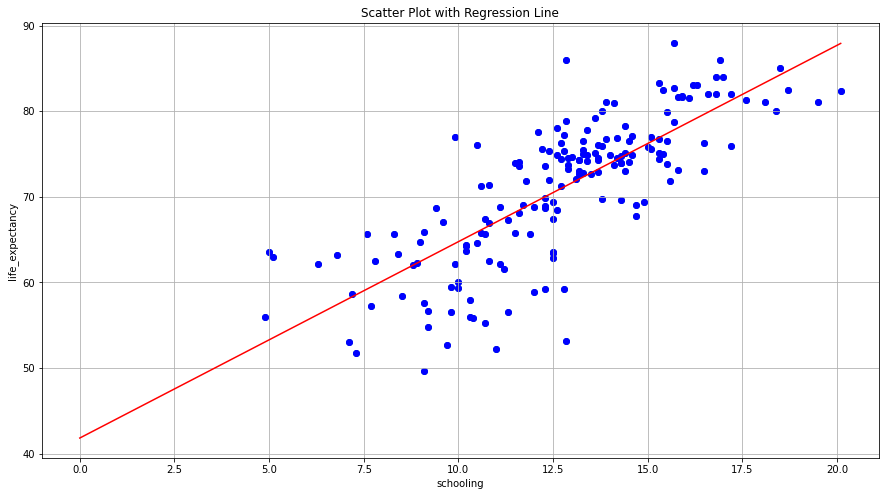

In [158]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["schooling"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["schooling"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(0, df.schooling.max(), 100)

# combining the two plots
plt.scatter(df["schooling"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("schooling")
plt.grid()

The slope of the regression line is: 0.18402114107160206 The Intercept is: 55.24079470968922


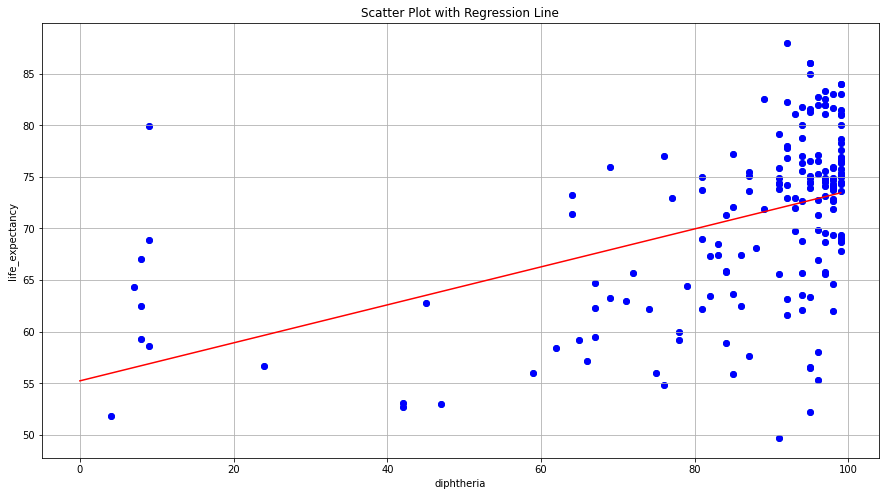

In [159]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["diphtheria"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["diphtheria"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(0, df.diphtheria.max(), 100)

# combining the two plots
plt.scatter(df["diphtheria"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("diphtheria")
plt.grid()

The slope of the regression line is: 0.21681306642119505 The Intercept is: 62.21881040446138


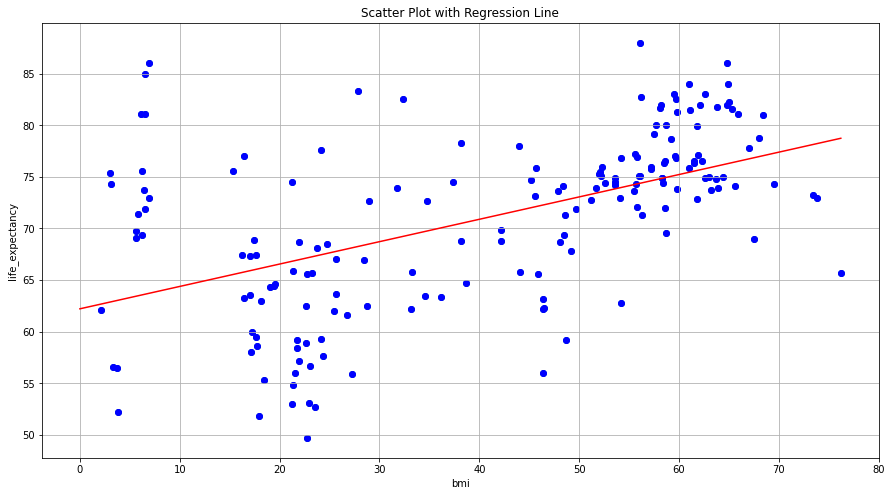

In [160]:
plt.figure(figsize = (15, 8))

# Create scatterplot between two variables
plt.scatter(df["bmi"], df["life_expectancy"])

# Create regression line
m,b = np.polyfit(df["bmi"], df["life_expectancy"], deg = 1)
print("The slope of the regression line is:", m, "The Intercept is:", b)

# Create a series of equaly spaced values
x_range = np.linspace(0, df.bmi.max(), 100)

# combining the two plots
plt.scatter(df["bmi"], df["life_expectancy"],color = "blue")
plt.plot(x_range, m*x_range+b, color = "red")
plt.title("Scatter Plot with Regression Line")
plt.ylabel("life_expectancy")
plt.xlabel("bmi")
plt.grid()

Part (c)
Linearities with the variables

As per the Harvey-Collier Test performed above, there are no non-linearities within our model and therefore require no transformations. 

However, if we do include non-linear variables in the regression model, we break the linearity assumption of the Ordinary Least Squares regression model. Due to this, our parameter estimates would be biased, the model would have poor performance and the results will be inaccurate.

Part (d)

Finding, if there are outliers in the model.

DFFITS

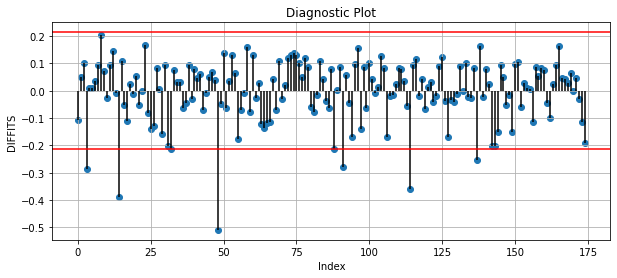

In [161]:
reg = smf.ols('life_expectancy ~ alcohol', data = df)
alc = reg.fit()
dffits, threshold = alc.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

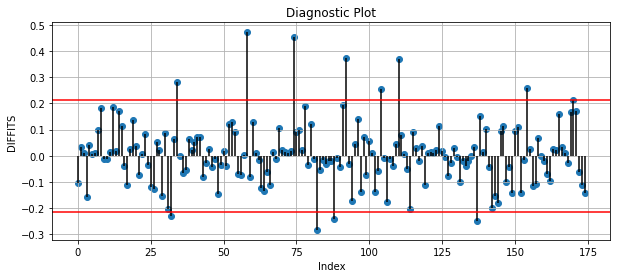

In [162]:

reg = smf.ols('life_expectancy ~ bmi', data = df)
bmi = reg.fit()
dffits, threshold = bmi.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

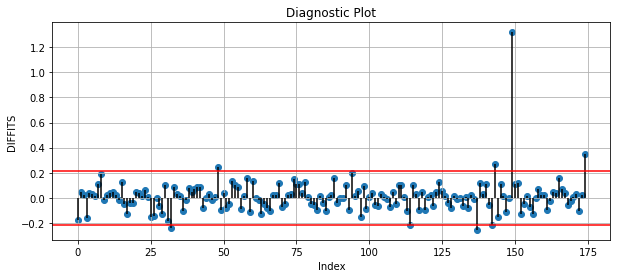

In [163]:

reg = smf.ols('life_expectancy ~ hiv_aids', data = df)
hiv = reg.fit()
dffits, threshold = hiv.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

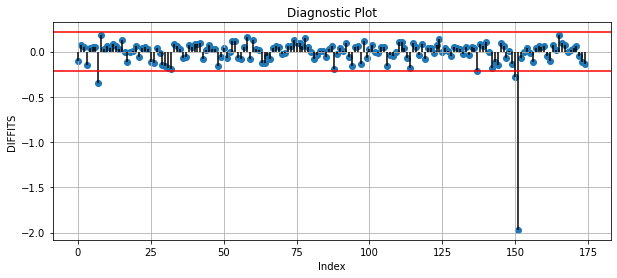

In [164]:
reg = smf.ols('life_expectancy ~ percentage_expenditure', data = df)
per = reg.fit()
dffits, threshold = per.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

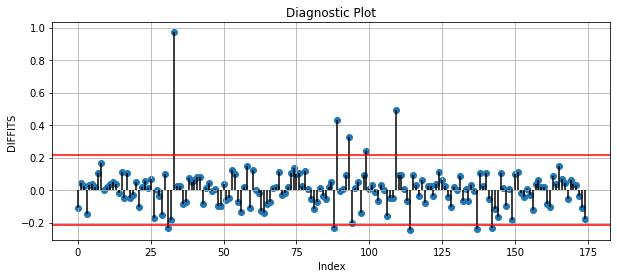

In [165]:
reg = smf.ols('life_expectancy ~ diphtheria', data = df)
dip = reg.fit()
dffits, threshold = dip.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

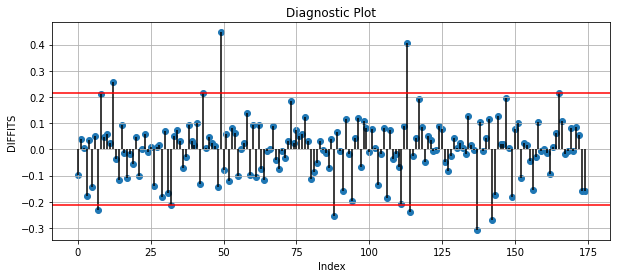

In [166]:

reg = smf.ols('life_expectancy ~ schooling', data = df)
school = reg.fit()
dffits, threshold = school.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

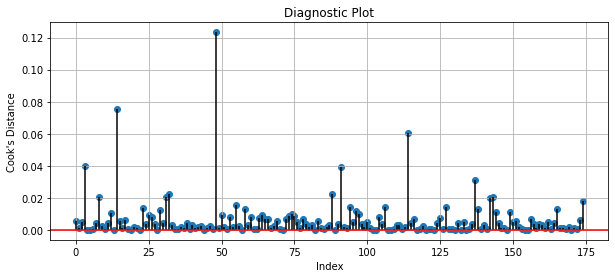

In [167]:
reg = smf.ols('life_expectancy ~ alcohol', data = df)
alc = reg.fit()
cooks_distance = alc.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

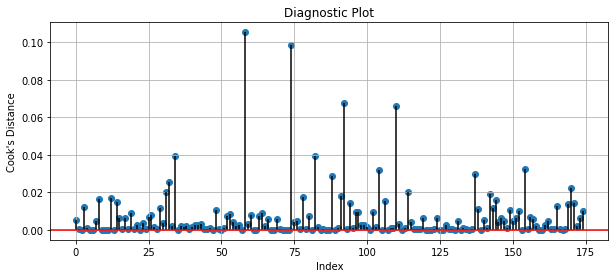

In [168]:
reg = smf.ols('life_expectancy ~ bmi', data = df)
bmi = reg.fit()
cooks_distance = bmi.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

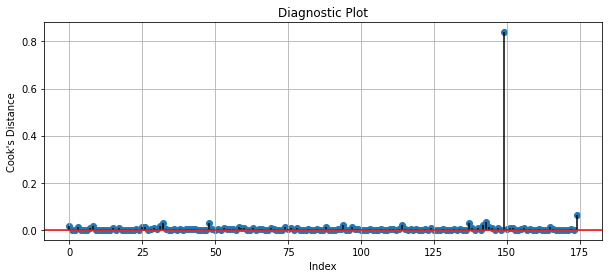

In [169]:
reg = smf.ols('life_expectancy ~ hiv_aids', data = df)
hiv = reg.fit()
cooks_distance = hiv.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

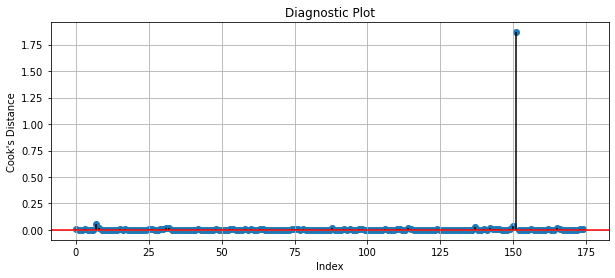

In [170]:
reg = smf.ols('life_expectancy ~ percentage_expenditure', data = df)
per = reg.fit()
cooks_distance = per.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

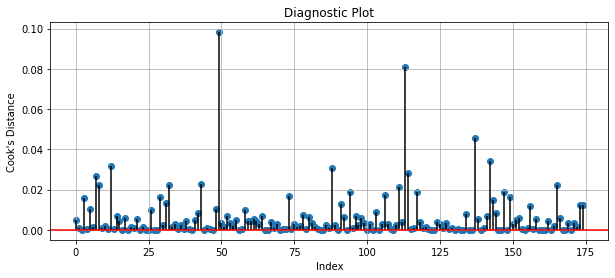

In [171]:
cooks_distance = school.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

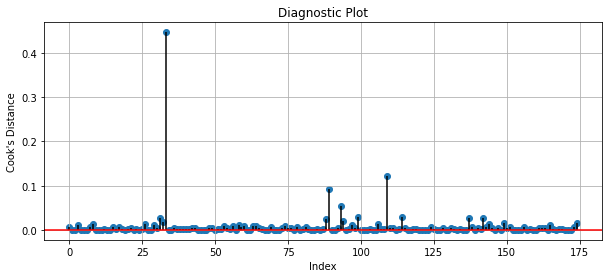

In [172]:
reg = smf.ols('life_expectancy ~ diphtheria', data = df)
diphtheria = reg.fit()
cooks_distance = diphtheria.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

Using Cook's Distance as our test for influentail observations, we removed outliers using the estimated cutoff.

This has been done in Question 3.

In [173]:
df.diphtheria

0      67
1      99
2      95
3      75
4      98
       ..
170    81
171    97
172    67
173    78
174    95
Name: diphtheria, Length: 175, dtype: int64

Part (e)

We see that there are NA values present in the dataset. Therefore, in order to impute them, we add the median values instead. The reason for not replacing them with the mean values is because there are extreme values present in the dataset. Due to there being extreme values, median seemed like the more appropriate tool to use in order to impute NA values.

This has been done above as well.

### Question 3

### Evaluating Transformations
From the Harvey-Collier test performed above, we see that our model is linearly specified and does not require any transformation. 

Furthermore, we see from the Ramsey-Reset test below that our model does not require any interaction variables as well. 


In [174]:
import statsmodels.formula.api as smf
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels

### Test for Multicollinearity

In [175]:
## Selected model
reg = smf.ols(pref_model, data = df)
results1 = reg.fit()

In [176]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     90.41
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           1.75e-56
Time:                        02:07:36   Log-Likelihood:                -474.49
No. Observations:                 175   AIC:                             967.0
Df Residuals:                     166   BIC:                             995.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 52.5525      2.013     26.103      0.000      48.578      56.527
alcohol                    0.1489      0.086      1.730      0.086      -0.021       0.319
bmi                        0.0458      0.016      2.838      0.005       0.014       0.078
percentage_expenditure     0.0005      0.000      3.547      0.001       0.000       0.001
hiv_aids                  -1.2715      0.185     -6.874      0.000      -1.637      -0.906
diphtheria                 0.0431      0.015      2.846      0.005       0.013       0.073
schooling                  1.1041      0.153      7.220      0.000       0.802       1.406
Africa                    -3.2557      0.935     -3.484      0.001      -5.101      -1.411
Oceania                   -2.7551      1.275     -2.161      0.032      -5.273      -0.238
==============================================================================
Omnibus:                        9.564   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.254
Skew:                          -0.335   Prob(JB):                      0.00132
Kurtosis:                       4.170   Cond. No.                     1.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



By just visually inspecting the summary statistics, we see that the p-values of our predictors are all below 0.05 i.e. they are all statistically significant. Furthermore, the adjusted R^2 is pretty good as well, standing at approximately 0.869 which means that about 87% of the the regression is explained by our model. 

Both these observations show that there might not be multicollinearity present in the dataset. However, we will conduct further checks for the same.

In [177]:
import patsy as pt
import statsmodels.stats.outliers_influence as smo

# Get the design matrix
y, X = pt.dmatrices(pref_model, data = df,
                   return_type = 'dataframe')

X

,Intercept,alcohol,bmi,percentage_expenditure,hiv_aids,diphtheria,schooling,Africa,Oceania
0,1.0,0.01,17.6,78.184215,0.1,67.0,9.8,0.0,0.0
1,1.0,5.14,55.8,412.443356,0.1,99.0,14.2,0.0,0.0
2,1.0,0.66,56.1,555.926083,0.1,95.0,14.4,1.0,0.0
3,1.0,8.24,21.5,256.122524,2.6,75.0,10.3,1.0,0.0
4,1.0,8.18,45.7,2156.229842,0.2,98.0,13.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...
170,1.0,6.70,6.4,217.212579,0.1,81.0,14.1,0.0,0.0
171,1.0,4.12,15.3,217.212579,0.1,97.0,12.2,0.0,0.0
172,1.0,0.04,38.7,217.212579,0.1,67.0,9.0,0.0,0.0
173,1.0,2.59,21.7,196.915250,5.6,78.0,12.3,1.0,0.0


Variance Inflation Factors (VIF)

In [178]:
#  Pull the number of regressors (+ intercept)
k = X.shape[1]

# create an empty matrix to store results
VIF = np.empty(k)

# Loop for each regressor (+ intercept)
for i in range(k):
    
    # calculate the VIF for each
    VIF[i] = smo.variance_inflation_factor(X.values, i)

print('VIF:', VIF)

VIF: [50.73807078  1.66062147  1.36288559  1.28283261  1.68830389  1.28617184
  2.40583405  2.25755832  1.09639045]


By using Variance Inflation Factor (VIF), we try and check if there is any multicollinearity among the variables. The VIF method shows how much the variance increases due to the presence of correlation among predictors. It measures the variance by regressing predictor on predictor i.e. running an auxilliary regression. This way, we get dufferent values of R^2 from the regressions. 

By rule of thumb, we take the threshold of VIF values as either 4 or 10 depending on how the values are. In our instance, the threshold we take is 4. As we can see, all the values are below 4, hence we can again conclude that there seems to be no presence of multicollinearity in the model. 

## Heteroskedasticity 

In [179]:

def spread_level(model, data):
    df_copy = df.copy()
    
    # Get the studentized residuals
    df_copy["Absolute_Studentized_Residuals"] = (np.abs(model.get_influence().resid_studentized))
    df_copy["Fitted_Values"] = (model.fittedvalues)
    
    # run regression to get slope of fitted vs resid, rlm is a robust linear model used by R
    slreg = smf.rlm("np.log(Absolute_Studentized_Residuals) ~ np.log(Fitted_Values)", df_copy).fit()
    slope = slreg.params[1]
    
    # plot values
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_title("Fitted Values vs Studentized Residuals")
    sns.regplot(x = "Fitted_Values", y = "Absolute_Studentized_Residuals", data = df_copy, lowess = True, ax = ax)
    ax.plot(df_copy.Fitted_Values.values, np.exp(slreg.fittedvalues).values)
    
    # Set to the logarithmic scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # convert froms scientific notation to scalar notation
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    # Resolve overlapping label bug
    ax.minorticks_off()
    
    # Set tick labels automatically
    ax.set_xticks(np.linspace(df_copy["Fitted_Values"].min(),df_copy["Fitted_Values"].max(), 6))
    ax.set_yticks(np.linspace(df_copy["Absolute_Studentized_Residuals"].min(),
                              df_copy["Absolute_Studentized_Residuals"].max(), 6))
    
    ax.grid()
    
    # return a suggested power transform of your y-variable that may correct heteroscedastcity
    # The transform is just one minus the slope of the reegression line of your fitted values vs residuals
    print("Suggested Power Transformation:", 1-slope)

In [180]:
import statsmodels.formula.api as smf
from matplotlib.ticker import ScalarFormatter

Suggested Power Transformation: 1.0285380866401956


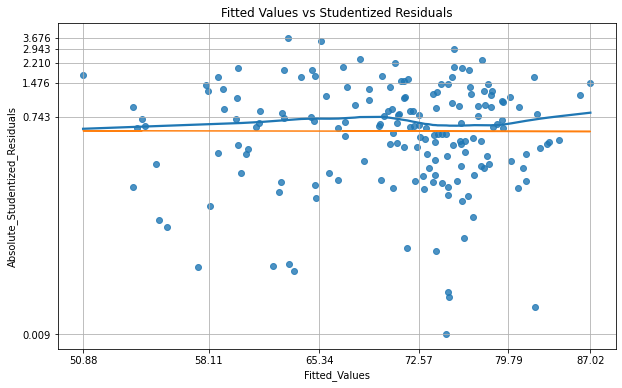

In [181]:
model = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', df)
results = model.fit()
spread_level(results, df)

By visually inspecting the Spread-Level Plot above, we see that there does not seem to be a any evidence of increasing variance as the fitted values get larger. This suggests that there seems to be no presence of heteroskedasticity in our model. 

We further conduct tests to verify our intuition.  To further verify our results, we are conducting BP test, White test. For indicator variables , we are conducting GQ test.  

#### Breush-Pagan Test

In [182]:

df["res3"] = results1.resid**2

# try to predict the squared residuals using a linear combination of our variables
aux_reg = smf.ols('res3 ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', df).fit()

# Get the regression f-statistic (f-test version)
f = aux_reg.fvalue
fp = aux_reg.f_pvalue

print("The F-Statistic for the Auxiliary Regression is: "+ str(f) +" and the P-Value is: "+ str(fp))

The F-Statistic for the Auxiliary Regression is: 1.4859372199670122 and the P-Value is: 0.16575309612913972


In [183]:

sm.stats.diagnostic.het_breuschpagan(results1.resid, X)

(11.694538031917157,
 0.1653620031268073,
 1.4859372199670084,
 0.1657530961291411)

The Breush-Pagan test tells about any heteroskedasticity present in our model. From the above function, we see that the p-value is about 0.16, which is greater than 0.05. This means that we fail to reject the null. The null, in this case, being that there is no heteroskedasticity. 

Therefore, we can say that there is no evidence of heteroskedasticity in the model, as per the BP-Test

#### White-Test

In [184]:
sm.stats.diagnostic.het_white(results1.resid, X)

(40.35598544723332, 0.4990798673459415, 0.9722740372555461, 0.5263256231787328)

The white test also gives us a p-value of 0.52, which tells us that we fail to reject the null, ultimately showing that there is no presence of heteroskedasticity in the model. 

#### Godlfield-Quant test

In [185]:
# manual implementation
data1 = df[df.Africa == 1]
data0 = df[df.Africa == 0]

# run regs on different groups
reg1 = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data1).fit()
reg0 = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data0).fit()

# pull out the residuals of each regression
df1 = reg1.df_resid
df0 = reg0.df_resid

# Get the variance of each regression
sig1squared = reg1.scale
sig0squared = reg0.scale

fstat = sig1squared/sig0squared

# calculate critical calue for right side test
stats.f.ppf(.95, df1, df0)

1.4814643707028299

In [186]:
fstat

1.3049587910521845

We see that the critical value is greater than the fstat, which means that we fail to reject the null. The null, is this case, is that the variance of of the two groups created above are the same. This means that the variance has remained constant. Hence, this further proves that there is no presence of Heteroskedasticity in our model. 

In [187]:
# manual implementation
data1 = df[df.Oceania == 1]
data0 = df[df.Oceania == 0]

# run regs on different groups
reg1 = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data1).fit()
reg0 = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data0).fit()

# pull out the residuals of each regression
df1 = reg1.df_resid
df0 = reg0.df_resid

# Get the variance of each regression
sig1squared = reg1.scale
sig0squared = reg0.scale

fstat = sig1squared/sig0squared

# calculate critical calue for right side test
stats.f.ppf(.95, df1, df0)

2.662196418824825

In [188]:
fstat

0.5537932759452712

In [189]:
df.Oceania.sum()

10

We see that the critical value is greater than the fstat, which means that we fail to reject the null. The null, is this case, is that the variance of of the two groups created above are the same. This means that the variance has remained constant. Hence, this further proves that there is no presence of Heteroskedasticity in our model. 

### Testing if the model is misspecified using Reset test

In [190]:
### Reset ramsey for model misspecification

reset_out = statsmodels.stats.outliers_influence.reset_ramsey(res = results1, degree = 2)
reset_out

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.44152746]]), p=0.2316131473981652, df_denom=165, df_num=1>

We see that the p-value is greater than 0.05. This means that we fail to reject to null, which here, is that the model is correctly specified. Hence, we can say that our model is correctly specified does not require any interaction variables and hence is correctly specified.

In [191]:
import patsy as pt
import statsmodels.api as sm

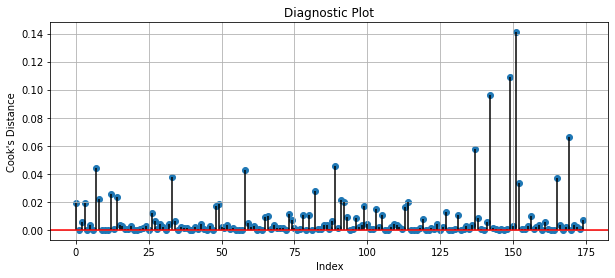

In [192]:
# Cook's Distance plot
cooks_distance = results1.get_influence().cooks_distance
plt.figure(figsize = (10, 4))
plt.scatter(df.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()


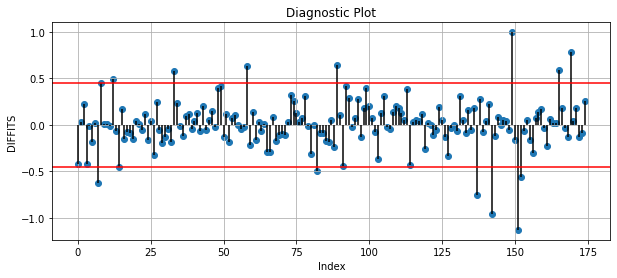

In [193]:
dffits, threshold = results1.get_influence().dffits
plt.figure(figsize = (10,4))
plt.scatter(df.index, dffits)
plt.axhline(threshold, color = 'red')
plt.axhline(-threshold, color = 'red')
plt.vlines(x = df.index, ymin = 0, ymax = dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title("Diagnostic Plot")
plt.grid()

In [194]:
df = df[cooks_distance[0]<4/len(cooks_distance[0])]

Removing any unusual variables present in the multivariate regression using cooks distance.

#### Residual Plot 

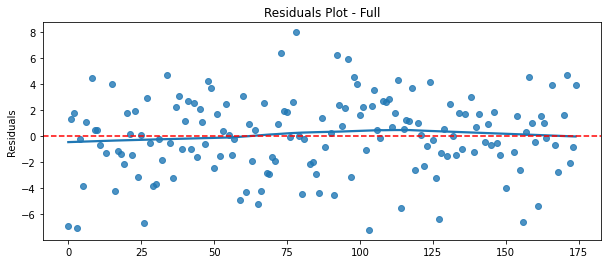

In [195]:

reg = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data = df).fit()
plt.figure(figsize = (10, 4))
sns.regplot(x = df.index, y = reg.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot - Full")
plt.show()

QQ Plot

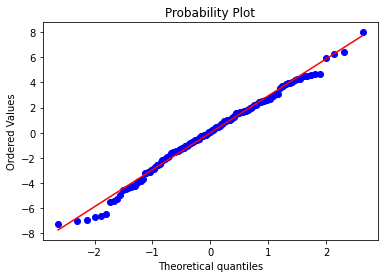

In [227]:
stats.probplot(results1.resid, dist="norm", plot=plt)
plt.show()

As we can see through the QQ plot as well, we can reinforce the result that our residuals are approximately normally distributed. 

## Comparing competing models using AIC and BIC




We have chosen an alternative model from running the Mallow CP when indicator variables were not included in the model in order to compare top models with and without indicator variables.

In [197]:
## An alternate model we are comparing our models with ****
alt_pref_model
reg = smf.ols(alt_pref_model, data = df)
results_alt = reg.fit()
results_alt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     139.9
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           3.63e-63
Time:                        02:08:55   Log-Likelihood:                -403.68
No. Observations:                 161   AIC:                             823.4
Df Residuals:                     153   BIC:                             848.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 49.7458      1.566     31.766      0.000      46.652      52.840
alcohol                    0.1663      0.074      2.258      0.025       0.021       0.312
bmi                        0.0489      0.014      3.436      0.001       0.021       0.077
total_expenditure          0.1247      0.100      1.250      0.213      -0.072       0.322
percentage_expenditure     0.0008      0.000      5.046      0.000       0.000       0.001
hiv_aids                  -1.7508      0.149    -11.722      0.000      -2.046      -1.456
diphtheria                 0.0502      0.015      3.450      0.001       0.021       0.079
schooling                  1.1274      0.131      8.639      0.000       0.870       1.385
==============================================================================
Omnibus:                        1.740   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.320
Skew:                          -0.182   Prob(JB):                        0.517
Kurtosis:                       3.254   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
Model1_bic = results1.bic
Model2_bic = results_alt.bic

In [199]:
print('model 1 BIC:',Model1_bic)

model 1 BIC: 995.4637064747459


In [200]:
print('Alternate model BIC:',Model2_bic)

Alternate model BIC: 848.0126368102004


In [202]:
Model1_aic = results1.aic
Model2_aic = results_alt.aic

In [201]:
print('model 1 AIC:',Model1_aic)

model 1 AIC: 966.9806327094343


In [203]:
print('Alternate model AIC:',Model2_aic)

Alternate model AIC: 823.3614018903247


On comparing competing models, the perefered model ( model 1)  is the best model for our analysis because the prefered model has a lower AIC and BIC. This model is life_expectancy ~ alcohol + bmi + percentage_expenditure + hiv_aids + diphtheria + schooling + Africa + Oceania.


In [204]:
reg = smf.ols(pref_model, data = df)
results1 = reg.fit()

#### Bootstrapping 

In [205]:
# bootstrapping
# Bootstrapped Estimation

est = smf.ols('life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', df).fit()  # single estimate


n_boots = 500

boot_slopes1, boot_slopes2, boot_slopes3, boot_slopes4, boot_slopes5  = [], [], [], [], []
boot_slopes6, boot_slopes7, boot_slopes8                             = [], [], []

boot_interc = []
boot_adjR2 = []
n_points = df.shape[0]

plt.figure()
for _ in range(n_boots):
 # sample the rows, same size, with replacement
    sample_df = df.sample(n=n_points, replace=True)
 # fit a linear regression
    ols_model_temp = smf.ols(formula = 'life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data=sample_df)  
    results_temp = ols_model_temp.fit()
 
 # append coefficients
    boot_interc.append(results_temp.params[0])
    boot_slopes1.append(results_temp.params[1])
    boot_slopes2.append(results_temp.params[2])
    boot_slopes3.append(results_temp.params[3])
    boot_slopes4.append(results_temp.params[4])
    boot_slopes5.append(results_temp.params[5])
    boot_slopes6.append(results_temp.params[6])
    boot_slopes7.append(results_temp.params[7])
    boot_slopes8.append(results_temp.params[8])

    boot_adjR2.append(results_temp.rsquared_adj)

<Figure size 432x288 with 0 Axes>

In [206]:
    ols_model_temp = smf.ols(formula = 'life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania', data=sample_df)  
    results_temp = ols_model_temp.fit()
    results_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     134.8
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           5.02e-65
Time:                        02:09:23   Log-Likelihood:                -394.46
No. Observations:                 161   AIC:                             806.9
Df Residuals:                     152   BIC:                             834.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 53.5080      1.741     30.730      0.000      50.068      56.948
hiv_aids                  -1.3930      0.168     -8.276      0.000      -1.726      -1.060
schooling                  0.9333      0.124      7.514      0.000       0.688       1.179
alcohol                    0.0766      0.072      1.058      0.292      -0.067       0.220
percentage_expenditure     0.0008      0.000      5.478      0.000       0.000       0.001
diphtheria                 0.0391      0.014      2.864      0.005       0.012       0.066
bmi                        0.0729      0.014      5.198      0.000       0.045       0.101
Africa                    -2.7990      0.821     -3.408      0.001      -4.422      -1.176
Oceania                   -1.0435      1.296     -0.805      0.422      -3.604       1.517
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.417
Skew:                          -0.087   Prob(JB):                        0.812
Kurtosis:                       3.179   Cond. No.                     1.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

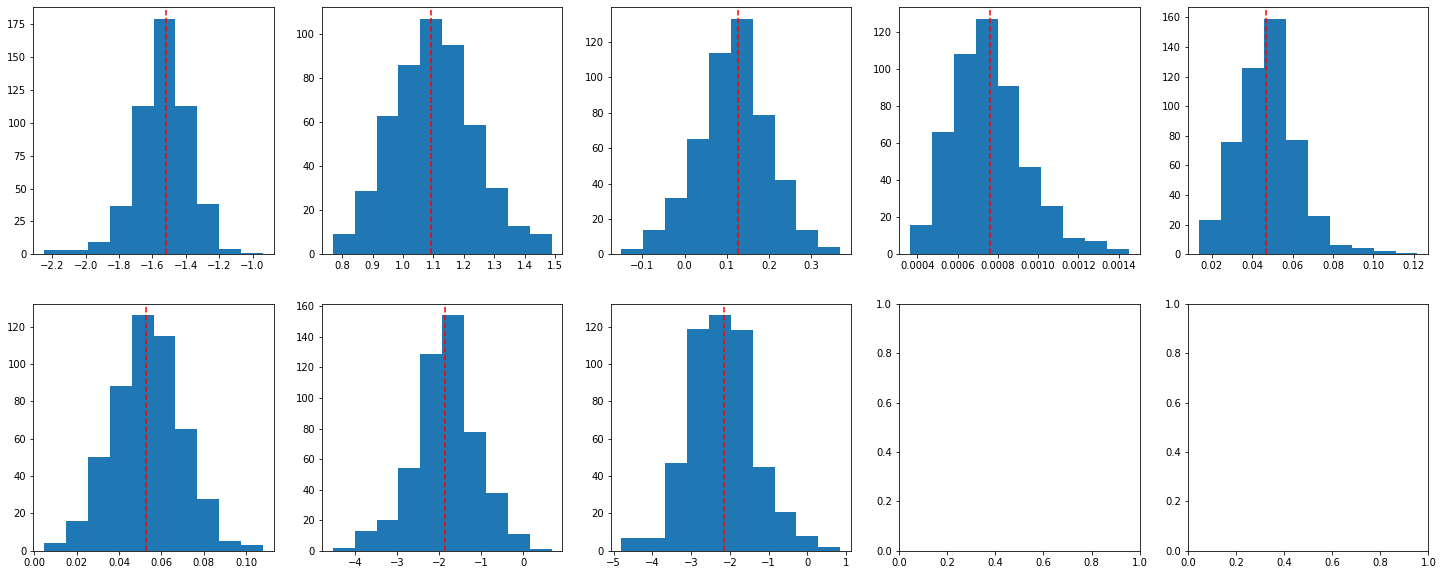

In [207]:
# histogram of bootstrapped estimates
fig, ax = plt.subplots(2, 5)

fig.set_size_inches(25, 10)

ax[0,0].set_title('')
ax[0, 0].hist(boot_slopes1) #row=0, col=0
ax[0, 0].axvline(x=est.params[1],color='red', linestyle='--')

ax[0, 1].hist(boot_slopes2) #row=0, col=0
ax[0, 1].axvline(x=est.params[2],color='red', linestyle='--')

ax[0, 2].hist(boot_slopes3) #row=0, col=0
ax[0, 2].axvline(x=est.params[3],color='red', linestyle='--')

ax[0, 3].hist(boot_slopes4) #row=0, col=0
ax[0, 3].axvline(x=est.params[4],color='red', linestyle='--')

ax[0, 4].hist(boot_slopes5) #row=0, col=0
ax[0, 4].axvline(x=est.params[5],color='red', linestyle='--')


ax[1, 0].hist(boot_slopes6) #row=0, col=0
ax[1, 0].axvline(x=est.params[6],color='red', linestyle='--')

ax[1, 1].hist(boot_slopes7) #row=0, col=0
ax[1, 1].axvline(x=est.params[7],color='red', linestyle='--')

ax[1, 2].hist(boot_slopes8) #row=0, col=0
ax[1, 2].axvline(x=est.params[8],color='red', linestyle='--')



#### K-Fold Cross Validation 

In [208]:
# 5 fold cross validation
# Perform 5-fold Cross Validation
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# 'life_expectancy ~ hiv_aids + schooling + alcohol + percentage_expenditure + diphtheria + bmi + Africa + Oceania' 

# Define model vars
x = df[['bmi' , 'alcohol', 'percentage_expenditure' ,'hiv_aids' , 'diphtheria' , 'schooling' , 'Africa' , 'Oceania']]
y = df[['life_expectancy']]

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('5-Fold CV RMSE Scores:', scores)

5-Fold CV RMSE Scores: [-3.31313465 -2.72832905 -3.62525063 -2.68887013 -2.75749281]


In [209]:
3/df.life_expectancy.mean()

0.04224317374801029

Across our five folds of out of sample predicitons of life-expectancy, the average RMSE is approximately 3 years. This is approximately a 4% error, which seems fairly good for predicting the life expectancy of each country.

[[ 6.28973427e-02  9.45391207e-02  5.80520455e-04 -1.33288899e+00
   5.96828716e-02  1.17946223e+00 -2.53896376e+00 -2.18916736e+00]]
MAE: 2.8332260249467427
MSE: 11.724483888342926
RMSE: 3.4241033699850427


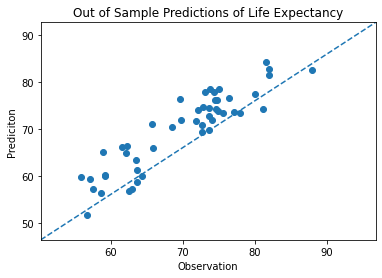

In [210]:
# Test Out of Sample Performance

# Define Model Vars
# x = df[['hiv_aids', 'adult_mortality' , 'schooling' , 'alcohol' , 'total_expenditure' , 'polio' , 'gdp' , 'percentage_expenditure' , 'diphtheria' , 'infant_deaths']]
# y = df[['life_expectancy']]


# Split the data into train  (70%)/test(30%) samples:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Train the model:
regr = LinearRegression()
regr.fit(x_train, y_train)

# Make predictions based on the test sample
y_pred = regr.predict(x_test)

# Evaluate Performance
print(regr.coef_)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

res_comp = pd.merge(y_test.reset_index(), pd.DataFrame(y_pred), left_index=True, right_index=True)

# plt.scatter(res_comp.iloc[:,1], res_comp.iloc[:,2])
plt.title('Out of Sample Predictions of Life Expectancy')
plt.scatter(y_test, y_pred)
plt.xlabel('Observation')
plt.ylabel('Prediciton')

xmax, xmin = y_test.max() * 1.10, y_test.min() * 0.90
ymax, ymin = y_pred.max() * 1.10, y_pred.min() * 0.90

plt.xlim([xmin[0],xmax[0]])
plt.ylim([ymin,ymax])

plt.plot(np.linspace(xmin[0],xmax[0]), np.linspace(ymin,ymax), linestyle ='--')

#### Marginal Effect

Because there are no quadratic or interaction terms in our model, the marginal effects are the estimated coefficients from the OLS regression results.  

# Conclusion

Of the 21 predictor variables we initially selected for analysis, we finalized an OLS regression model which is life expectancy = HIV and AIDs + schooling + alcohol + percentage and expenditure + diphtheria + BMI + Africa + Oceania using AIC, BIC and CP Mallow.  Our model has low VIF score indicating that there is no multicollinearity present between predictors. Additionally, 83 percent of the variation in y is explained by the model. Using the Harvey collier test, the test indicates that all our parameters are linear. This means that none of our parameters need any transformation, thus a one unit increase in each of the quantitative variables would lead to a beta increase/decrease in expected life expectancy on average. On using white test, BP test and the GQ test we also identify that our variable are not heteroskedastic, and after using the Ramsey reset test, we find that our preferred model is not mis-specified.  It is important to also note that the indicator variables which include Africa and Oceania, have a negative relationship between life expectancy and the indicator variables. Further, on the continent of Africa, life expectancy decreases on average by 3.25 and in Oceania, the life expectancy decreases by 2.75 on average. There is a negative relationship between HIV/AIDS deaths per thousand people and life expectancy.We would also like to conclude that in a univariate analysis, the number of HIV/AIDS deaths per thousand people is the variable is ranked the highest when conducting the boruta algorithm.

# References
1. Statistical Analysis on factors influencing Life Expectancy:(https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who (https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)
2. Econ 430 lecture material: Professor Randall R. Rojas
3. Econ 442A lecture material: Professor Nathan Kunz